In [1]:
import pandas as pd
import numpy as np

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Visualization (for inspection)
import matplotlib.pyplot as plt
import seaborn as sns


# Cleaning


In [2]:
# Load CSV file (specify encoding to avoid UnicodeDecodeError)
df = pd.read_csv("25k_IMDb_movie_Dataset.csv", engine='python', encoding='latin-1')

# Quick look
df.head()


,movie title,Run Time,Rating,User Rating,Generes,Overview,Plot Kyeword,Director,Top 5 Casts,Writer,year,path
0,Top Gun: Maverick,"$170,000,000 (estimated)",8.6,187K,"['Action', 'Drama']",After more than thirty years of service as one...,"['fighter jet', 'sequel', 'u.s. navy', 'fighte...",Joseph Kosinski,"['Jack Epps Jr.', 'Peter Craig', 'Tom Cruise',...",Jim Cash,-2022,/title/tt1745960/
1,Jurassic World Dominion,2 hours 27 minutes,6,56K,"['Action', 'Adventure', 'Sci-Fi']",Four years after the destruction of Isla Nubla...,"['dinosaur', 'jurassic park', 'tyrannosaurus r...",Colin Trevorrow,"['Colin Trevorrow', 'Derek Connolly', 'Chris P...",Emily Carmichael,-2022,/title/tt8041270/
2,Top Gun,"$15,000,000 (estimated)",6.9,380K,"['Action', 'Drama']",As students at the United States Navy's elite ...,"['pilot', 'male camaraderie', 'u.s. navy', 'gr...",Tony Scott,"['Jack Epps Jr.', 'Ehud Yonay', 'Tom Cruise', ...",Jim Cash,-1986,/title/tt0092099/
3,Lightyear,"$71,101,257",5.2,32K,"['Animation', 'Action', 'Adventure']",While spending years attempting to return home...,"['galaxy', 'spaceship', 'robot', 'rocket', 'sp...",Angus MacLane,"['Jason Headley', 'Matthew Aldrich', 'Chris Ev...",Angus MacLane,-2022,/title/tt10298810/
4,Spiderhead,not-released,5.4,23K,"['Action', 'Crime', 'Drama']","In the near future, convicts are offered the c...","['discover', 'medical', 'test', 'reality', 'fi...",Joseph Kosinski,"['Rhett Reese', 'Paul Wernick', 'Chris Hemswor...",George Saunders,-2022,/title/tt9783600/


In [3]:
print(df.shape)
df.info()


(24402, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24402 entries, 0 to 24401
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movie title   24402 non-null  object
 1   Run Time      24402 non-null  object
 2   Rating        24402 non-null  object
 3   User Rating   24402 non-null  object
 4   Generes       24402 non-null  object
 5   Overview      24158 non-null  object
 6   Plot Kyeword  24402 non-null  object
 7   Director      24402 non-null  object
 8   Top 5 Casts   24402 non-null  object
 9   Writer        24402 non-null  object
 10  year          23624 non-null  object
 11  path          24402 non-null  object
dtypes: object(12)
memory usage: 2.2+ MB


In [4]:
df.isnull().sum()

movie title       0
Run Time          0
Rating            0
User Rating       0
Generes           0
Overview        244
Plot Kyeword      0
Director          0
Top 5 Casts       0
Writer            0
year            778
path              0
dtype: int64

In [5]:
df = df.dropna(subset=["movie title", "Overview", "Top 5 Casts"])

# Remove rows where Run Time indicates 'not-released' (original code used a boolean expression by mistake)
df = df[~df["Overview"].astype(str).str.lower().str.contains("none", na=False)]

df["Overview"] = df["Overview"].astype(str)
df = df.drop_duplicates(subset=["movie title", "year"])

print("Cleaned dataset size:", df.shape)



Cleaned dataset size: (23518, 12)


In [6]:
def extract_top_cast(cast_str, n=3):
    if pd.isna(cast_str):
        return ""
    return " ".join(
        [f"actor_{actor.strip().replace(' ', '')}" 
         for actor in cast_str.split(",")[:n]]
    )

def clean_director(director):
    if pd.isna(director):
        return ""
    return f"director_{director.strip().replace(' ', '')}"



# Text Preprocessing

In [7]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text) 
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)


In [8]:
df["clean_overview"] = df["Overview"].apply(clean_text)
df["clean_genre"] = df["Generes"].apply(clean_text)
df["clean_cast"] = df["Top 5 Casts"].apply(lambda x: extract_top_cast(x, 5))
df["clean_director"] = df["Director"].apply(clean_director)



In [9]:
df["movie_profile"] = df["clean_overview"] + " " +df["Plot Kyeword"]+" "+ df["clean_genre"]+" "+ df["clean_director"]+ " " + df["clean_cast"]


df[["movie title", "movie_profile"]].head()


,movie title,movie_profile
0,Top Gun: Maverick,thirty year service one navy top aviator pete ...
1,Jurassic World Dominion,four year destruction isla nublar dinosaur liv...
2,Top Gun,student united state navy elite fighter weapon...
3,Lightyear,spending year attempting return home marooned ...
4,Spiderhead,near future convict offered chance volunteer m...


In [10]:
df = df.reset_index(drop=True)


# TF-IDF
TF(t,d)=
Total number of terms in document d
/
Number of times term t appears in document d
	​

IDF(t)=log(N/1+nt)

TF-IDF(t,d)=TF(t,d)×IDF(t)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=20000,
    max_df=0.9,
    min_df=3,
    ngram_range=(1, 2)
)



tfidf_matrix = tfidf.fit_transform(df["movie_profile"])
print("TF-IDF matrix shape:", tfidf_matrix.shape)



TF-IDF matrix shape: (23518, 20000)


In [15]:
tfidf.get_feature_names_out()[:100]


array(['007', '10', '11', '11th', '11th century', '12', '12 year', '13',
       '13 year', '13th', '13th century', '14', '14 year', '14th',
       '14th century', '15', '15 year', '15th', '15th century', '16',
       '16 year', '16th', '16th century', '17', '17 year', '1700s',
       '17th', '17th century', '18', '1800s', '1810s', '1830s', '1840s',
       '1850s', '1860s', '1870s', '1880s', '1890s', '1890s timeframe',
       '18th', '18th century', '1900s', '1910s', '1910s timeframe',
       '1917', '1918', '1920s', '1920s timeframe', '1930s',
       '1930s timeframe', '1940s', '1940s timeframe', '1941', '1942',
       '1943', '1944', '1944 1940s', '1944 year', '1945', '1950s',
       '1950s timeframe', '1959', '1960s', '1960s timeframe', '1962',
       '1963', '1969', '1970s', '1970s timeframe', '1973', '1976',
       '1980s', '1980s film', '1980s timeframe', '1984', '1989', '1990s',
       '1991', '1992', '1993', '1999', '19th', '19th century', '1st',
       '1st century', '2000s', '

# PCA

In [14]:
from sklearn.decomposition import TruncatedSVD


In [15]:
n_components = 70

svd = TruncatedSVD(n_components=n_components, random_state=42)
pca_features = svd.fit_transform(tfidf_matrix)



In [18]:
explained_variance = svd.explained_variance_ratio_
print("Total explained variance:", explained_variance.sum())


Total explained variance: 0.10260608525882559


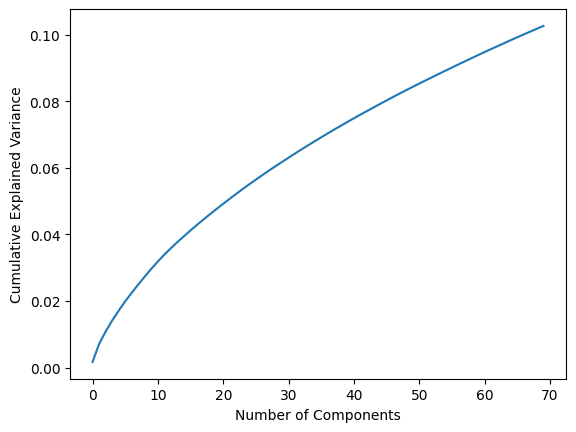

In [19]:
plt.plot(np.cumsum(explained_variance))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()


# remove outliers

In [16]:
from sklearn.cluster import DBSCAN


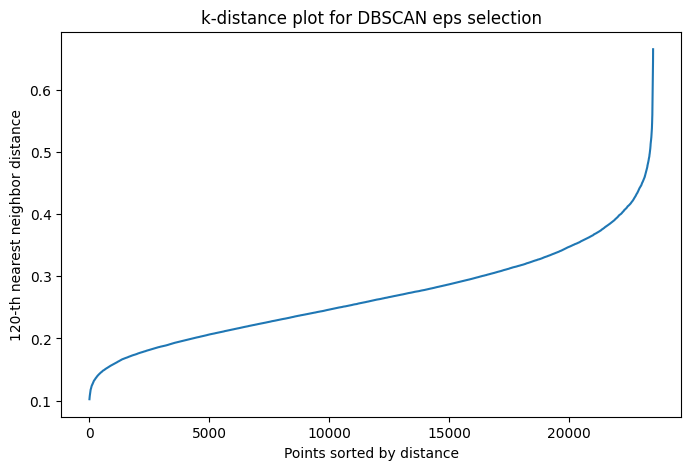

In [21]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

k = 120
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(pca_features)
distances, indices = neighbors_fit.kneighbors(pca_features)

# distance to kth nearest neighbor
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(8,5))
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-th nearest neighbor distance")
plt.title("k-distance plot for DBSCAN eps selection")
plt.show()


In [17]:
dbscan = DBSCAN(
    eps=0.4,
    min_samples=120
)

dbscan_labels = dbscan.fit_predict(pca_features)

df["dbscan_cluster"] = dbscan_labels



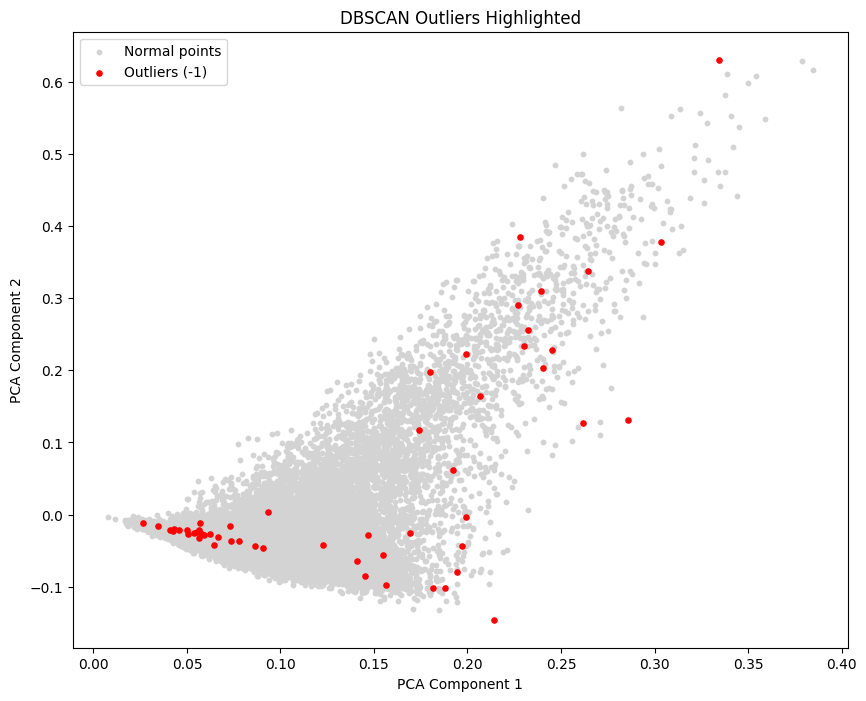

In [23]:
plt.figure(figsize=(10, 8))

# Mark non-outliers as one color (e.g., light gray)
non_outliers = dbscan_labels != -1
plt.scatter(
    pca_features[non_outliers, 0],
    pca_features[non_outliers, 1],
    c="lightgray",
    s=10,
    label="Normal points"
)

# Mark outliers as a strong color (e.g., red)
outliers = dbscan_labels == -1
plt.scatter(
    pca_features[outliers, 0],
    pca_features[outliers, 1],
    c="red",
    s=14,
    label="Outliers (-1)"
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Outliers Highlighted")
plt.legend()
plt.show()



In [24]:
outliers = df[df["dbscan_cluster"] == -1]
outliers["movie title"].head(10)


1699                           Exodus
3475    Bad Kids of Crestview Academy
3519              A Gnome Named Gnorm
5769                           HÃ¤jyt
6300                       Youngblood
6429                      Hell Riders
7242                Kondaveeti Simham
7518                          Matilda
7928                       Brightburn
8365              Tell It to the Bees
Name: movie title, dtype: object

In [18]:
# Identify outlier indices
outlier_indices = df[df["dbscan_cluster"] == -1].index

print("Removing", len(outlier_indices), "outliers")

# 1) Drop outliers from dataframe (save as df_clean_tfidf for TF-IDF approach)
df_clean_tfidf = df.drop(index=outlier_indices).reset_index(drop=True)

# 2) Drop outliers from PCA matrix
pca_clean = np.delete(pca_features, outlier_indices, axis=0)

# 3) Drop outliers from TF-IDF matrix
tfidf_clean = tfidf_matrix[np.delete(np.arange(tfidf_matrix.shape[0]), outlier_indices)]


Removing 54 outliers


# GMM

In [26]:
from sklearn.mixture import GaussianMixture


In [61]:
bic_scores = []
aic_scores = []
k_range = range(1,21) 

for k in k_range:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=42
    )
    gmm.fit(pca_clean)
    bic_scores.append(gmm.bic(pca_clean))
    aic_scores.append(gmm.aic(pca_clean))


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\mixture\_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\mixture\_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\mixture\_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for de

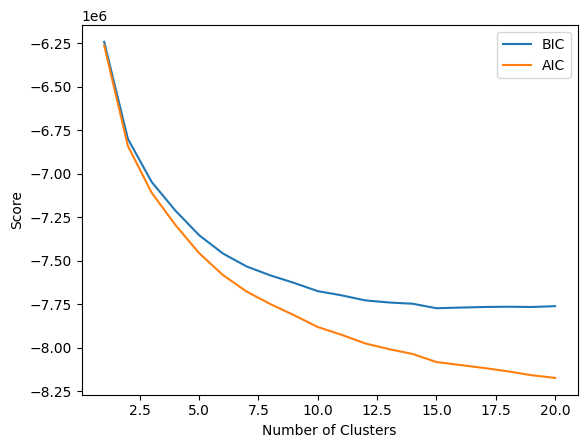

In [28]:
plt.plot(k_range, bic_scores, label="BIC")
plt.plot(k_range, aic_scores, label="AIC")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.legend()
plt.show()


In [62]:
optimal_k = 10

gmm = GaussianMixture(
    n_components=optimal_k,
    covariance_type="full",
    random_state=42
)

gmm_labels = gmm.fit_predict(pca_clean)


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\mixture\_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


In [63]:
df_clean_tfidf["gmm_cluster"] = gmm_labels
gmm_probs = gmm.predict_proba(pca_clean)
for cluster_id in range(optimal_k):
    print(f"\nCluster {cluster_id}")
    sample_titles = df_clean_tfidf[df_clean_tfidf["gmm_cluster"] == cluster_id]["movie title"].head(20)
    print(sample_titles.tolist())




Cluster 0
['Top Gun', 'Spiderhead', 'Blade Runner 2049', 'Kingsman: The Secret Service', 'Apocalypto', 'The Crow', 'Kill Bill: Vol. 1', 'Hitman', 'Triple Frontier', 'Children of Men', 'Revenge', 'Kate', 'Lucy', 'Hollow Man', '300: Rise of an Empire', 'Carriers', 'Layer Cake', 'Panama', 'Sin City: A Dame to Kill For', 'Spy']

Cluster 1
['Lightyear', 'Thor: Love and Thunder', 'The Unbearable Weight of Massive Talent', 'The Batman', 'Morbius', 'Eternals', 'Memory', "The King's Man", 'Aquaman', 'Venom: Let There Be Carnage', 'The Suicide Squad', 'Thor: Ragnarok', 'Guardians of the Galaxy', 'The Hunger Games: The Ballad of Songbirds and Snakes', 'Watchmen', 'Tenet', 'Shang-Chi and the Legend of the Ten Rings', 'The Hunger Games', 'Black Widow', 'Casino Royale']

Cluster 2
['Vikram', 'Road House', 'Wrath of Man', 'Spectre', 'Die Hard', 'Mad Max: Fury Road', 'Blacklight', 'Sicario', 'Tropic Thunder', 'Collateral', 'The 355', 'The Fast and the Furious', 'Hell or High Water', 'The Harder They 

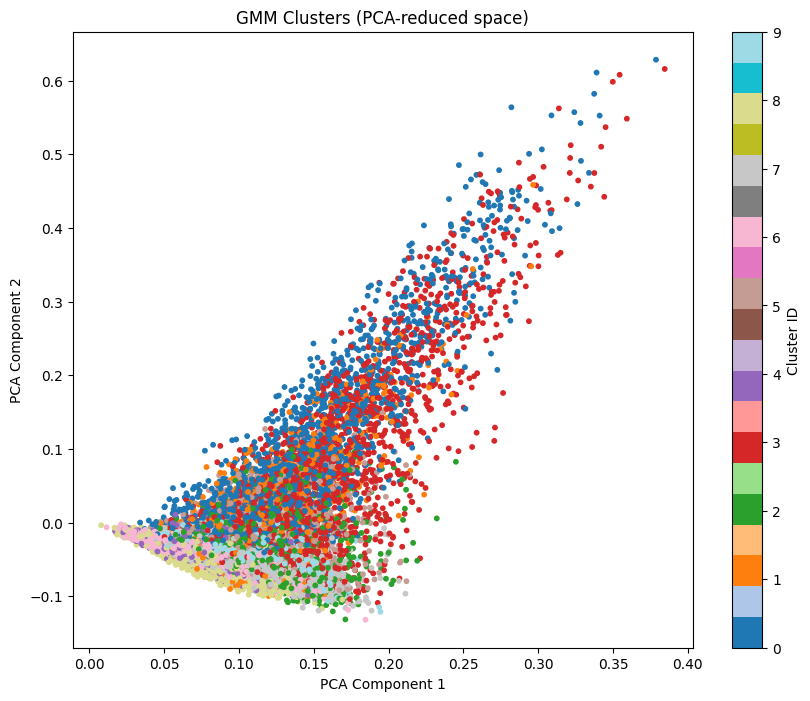

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(
    pca_clean[:, 0],
    pca_clean[:, 1],
    c=df_clean_tfidf["gmm_cluster"],
    cmap="tab20",
    s=10
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("GMM Clusters (PCA-reduced space)")
plt.colorbar(label="Cluster ID")
plt.show()


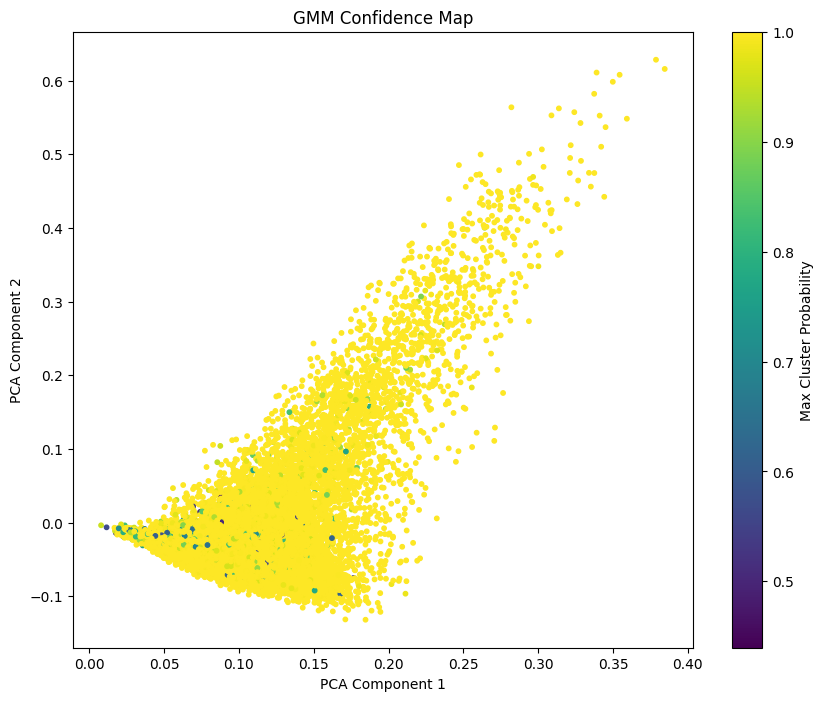

In [32]:
max_probs = gmm.predict_proba(pca_clean).max(axis=1)

plt.figure(figsize=(10, 8))
plt.scatter(
    pca_clean[:, 0],
    pca_clean[:, 1],
    c=max_probs,
    cmap="viridis", 
    s=10
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("GMM Confidence Map")
plt.colorbar(label="Max Cluster Probability")
plt.show()


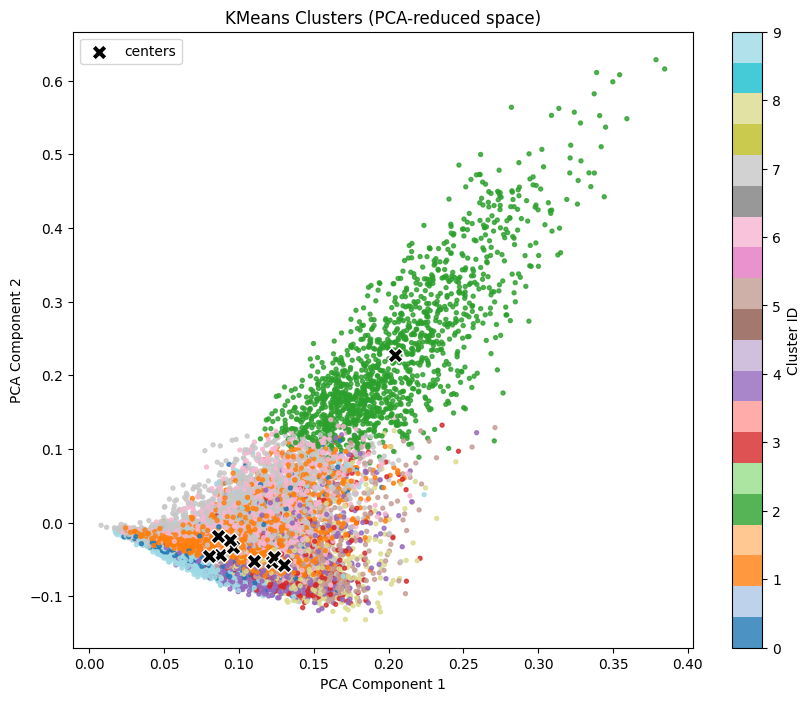

In [64]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.metrics.cluster import contingency_matrix
import pandas as pd
import numpy as np

# Use same number of clusters as GMM for fair comparison
n_clusters = optimal_k  # uses existing variable

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(pca_clean)

# attach to dataframe
df_clean_tfidf["kmeans_cluster"] = kmeans_labels

plt.figure(figsize=(10, 8))
sc = plt.scatter(
    pca_clean[:, 0],
    pca_clean[:, 1],
    c=df_clean_tfidf["kmeans_cluster"],
    cmap="tab20",
    s=8,
    alpha=0.8
)

# Plot KMeans centers (same PCA space)
if hasattr(kmeans, "cluster_centers_"):
    centers = kmeans.cluster_centers_
    plt.scatter(
        centers[:, 0],
        centers[:, 1],
        c="black",
        s=120,
        marker="X",
        edgecolor="white",
        linewidth=1,
        label="centers"
    )

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("KMeans Clusters (PCA-reduced space)")
plt.colorbar(sc, label="Cluster ID")
plt.legend()
plt.show()

In [34]:
df_clean_tfidf["kmeans_cluster"] = kmeans_labels

for cluster_id in range(n_clusters):
    print(f"\nCluster {cluster_id}")
    sample_titles = df_clean_tfidf[df_clean_tfidf["kmeans_cluster"] == cluster_id]["movie title"].head(20)
    print(sample_titles.tolist())




Cluster 0
["The King's Man", '1917', 'Dunkirk', 'Black Hawk Down', 'Fury', 'The Tomorrow War', 'Tropic Thunder', 'Wonder Woman', 'Wolf Hound', 'Allied', 'First Blood', 'Overlord', 'Captain America: The Winter Soldier', 'American Sniper', 'Tomorrow Never Dies', 'Midway', 'The Last of the Mohicans', 'Sicario: Day of the Soldado', 'The Last Castle', 'X-Men Origins: Wolverine']

Cluster 1
['Spiderhead', 'Bullet Train', 'Vikram', 'Last Seen Alive', 'Ambulance', 'Memory', 'The Dark Knight', 'The Gentlemen', 'The Contractor', 'Road House', 'Heat', 'Nobody', 'Spree', 'Watchmen', 'Operation Fortune: Ruse de guerre', 'Mission: Impossible III', 'White Elephant', 'Blacklight', 'Red Notice', 'Batman Begins']

Cluster 2
['The Northman', 'Blade Runner 2049', 'Den of Thieves', 'Conan the Barbarian', 'Red Sparrow', 'A History of Violence', 'Drive Angry', 'Scouts Guide to the Zombie Apocalypse', 'Barb Wire', 'Desperado', 'Panama', 'Sin City: A Dame to Kill For', 'Alexander', 'Outlaw King', 'Om - The Ba

# recommendation GMM

In [35]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_movies(
    movie_title,
    df_clean,
    tfidf_clean,
    top_n=10
):
    # 1 — Find movie index safely
    matches = df_clean.index[df_clean["movie title"].str.lower() == movie_title.lower()]
    if len(matches) == 0:
        raise ValueError("Movie title not found in dataset.")
    
    idx = matches[0]

    # 2 — Check DBSCAN outlier label
    movie_dbscan_label = df_clean.loc[idx, "dbscan_cluster"]

    if movie_dbscan_label == -1:
        # The movie itself is an outlier → no meaningful cluster
        # Fallback: compute similarity across NON-outliers only
        print("Note: Movie is an outlier in DBSCAN → using global similarity among non-outliers.")

        valid_indices = df_clean.index[df_clean["dbscan_cluster"] != -1].to_numpy()

        similarities = cosine_similarity(
            tfidf_clean[idx],
            tfidf_clean[valid_indices]
        ).flatten()

        top_positions = similarities.argsort()[::-1][1:top_n+1]
        top_indices = valid_indices[top_positions]

        return df_clean.loc[top_indices, ["movie title", "Generes", "Top 5 Casts", "Director"]]

    # 3 — Otherwise proceed normally (GMM cluster-based)
    cluster_id = df_clean.loc[idx, "gmm_cluster"]

    # Candidates = Same GMM cluster AND not DBSCAN outliers
    candidate_indices = df_clean.index[
        (df_clean["gmm_cluster"] == cluster_id) &
        (df_clean["dbscan_cluster"] != -1)
    ].to_numpy()

    # 4 — Compute similarity
    similarities = cosine_similarity(
        tfidf_clean[idx],
        tfidf_clean[candidate_indices]
    ).flatten()

    # 5 — Rank top movies
    top_positions = similarities.argsort()[::-1][1:top_n+1]
    top_indices = candidate_indices[top_positions]

    return df_clean.loc[top_indices, ["movie title", "Generes", "Top 5 Casts", "Director"]]


In [37]:
# call without passing the cluster array (the function uses df["gmm_cluster"] internally)
recommend_movies(
    "Spider-Man",
    df_clean_tfidf,
    tfidf_clean,
    top_n=10
)


,movie title,Generes,Top 5 Casts,Director
5976,Spider Man: Lost Cause,"['Action', 'Adventure', 'Comedy']","['Stan Lee', 'Joey Lever', 'Joey Lever', 'Crai...",Joey Lever
164,Spider-Man 3,"['Action', 'Adventure', 'Sci-Fi']","['Ivan Raimi', 'Alvin Sargent', 'Tobey Maguire...",Sam Raimi
202,Spider-Man: Far from Home,"['Action', 'Adventure', 'Sci-Fi']","['Erik Sommers', 'Stan Lee', 'Tom Holland', 'S...",Jon Watts
108,Spider-Man: Homecoming,"['Action', 'Adventure', 'Sci-Fi']","['John Francis Daley', 'Jon Watts', 'Tom Holla...",Jon Watts
6832,Average Joe,"['Action', 'Comedy']","['Camden Toy', 'Jason Sedillo', 'Caitlin Rose ...",Mark Cantu
812,Superhero Movie,"['Action', 'Comedy', 'Sci-Fi']","['Drake Bell', 'Leslie Nielsen', 'Sara Paxton'...",Craig Mazin
271,Power Rangers,"['Action', 'Adventure', 'Fantasy']","['Matt Sazama', 'Burk Sharpless', 'Dacre Montg...",Dean Israelite
4570,Super Capers: The Origins of Ed and the Missin...,"['Action', 'Adventure', 'Comedy']","['Justin Whalin', 'Ray Griggs', 'Danielle Harr...",Ray Griggs
1928,Only the Strong,"['Action', 'Drama']","['Luis Esteban', 'Mark Dacascos', 'Stacey Trav...",Sheldon Lettich
5915,Zebraman,"['Action', 'Comedy', 'Sci-Fi']","['ShÃ´ Aikawa', 'KyÃ´ka Suzuki', 'Atsuro Watab...",Takashi Miike


In [38]:
recommend_movies(
    "django unchained",
    df_clean_tfidf,
    tfidf_clean,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
7413,Ned,"['Action', 'Comedy', 'Western']","['Felix Williamson', 'Abe Forsythe', 'Damon He...",Abe Forsythe
7738,The Hateful Eight,"['Crime', 'Drama', 'Mystery']","['Samuel L. Jackson', 'Kurt Russell', 'Jennife...",Quentin Tarantino
7558,Inglourious Basterds,"['Adventure', 'Drama', 'War']","['Brad Pitt', 'Diane Kruger', 'Eli Roth', 'Que...",Quentin Tarantino
10163,The Birth of a Nation,"['Drama', 'History', 'War']","['D.W. Griffith', 'Frank E. Woods', 'Lillian G...",D.W. Griffith
8078,BlacKkKlansman,"['Biography', 'Comedy', 'Crime']","['David Rabinowitz', 'Kevin Willmott', 'John D...",Spike Lee
7680,Reservoir Dogs,"['Crime', 'Drama', 'Thriller']","['Roger Avary', 'Harvey Keitel', 'Tim Roth', '...",Quentin Tarantino
8721,Mississippi Burning,"['Crime', 'Drama', 'History']","['Gene Hackman', 'Willem Dafoe', 'Frances McDo...",Alan Parker
22395,The FBI Story,"['Crime', 'Drama', 'History']","['John Twist', 'Don Whitehead', 'James Stewart...",Mervyn LeRoy
2987,Sukiyaki Western Django,"['Action', 'Western']","['Masa Nakamura', 'Hideaki ItÃ´', 'KÃ´ichi Sat...",Takashi Miike
1767,Smokey and the Bandit Part 3,"['Action', 'Comedy', 'Crime']","['David Dashev', 'Jackie Gleason', 'Jackie Gle...",Dick Lowry


In [39]:
recommend_movies(
    "Batman begins",
    df_clean_tfidf,
    tfidf_clean,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
43,The Dark Knight,"['Action', 'Crime', 'Drama']","['Christopher Nolan', 'David S. Goyer', 'Chris...",Christopher Nolan
133,The Dark Knight Rises,"['Action', 'Drama']","['Christopher Nolan', 'David S. Goyer', 'Chris...",Christopher Nolan
3632,Batman Beyond,['Action'],"['Wyatt Brewer', 'Samuel P. Espinoza', 'Ryan G...",Brock Zych
2184,Batman Ninja,"['Animation', 'Action', 'Sci-Fi']","['Leo Chu', 'Eric Garcia', 'KÃ´ichi Yamadera',...",Junpei Mizusaki
3779,Zatanna,"['Action', 'Adventure', 'Fantasy']","['Gardner Fox', 'Murphy Anderson', 'Emerald Fe...",Murphy Anderson
1861,Constantine 2,"['Action', 'Fantasy', 'Horror']","['John Ridgway', 'Steve Bissette', 'Jamie Dela...",Steve Bissette
7010,Static Shock,"['Action', 'Adventure', 'Sci-Fi']","['Dwayne McDuffie', 'Randy McKinnon', 'United ...",Dwayne McDuffie
115,The Flash,"['Action', 'Adventure', 'Fantasy']","['Joby Harold', 'Ezra Miller', 'Ben Affleck', ...",Andy Muschietti
5235,Deathstroke,"['Action', 'Adventure', 'Crime']","['Marv Wolfman', 'Gareth Evans', 'George PÃ©re...",Gareth Evans
4179,Nightwing,['Action'],"['George PÃ©rez', 'Marv Wolfman', 'Chris McKay...",Chris McKay


In [40]:
recommend_movies(
    "grown ups",
    df_clean_tfidf,
    tfidf_clean,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
17059,Billy Madison,['Comedy'],"['Adam Sandler', 'Adam Sandler', 'Darren McGav...",Tamra Davis
21295,My Daughter Vanished,['Thriller'],"['Diora Baird', 'Blanche Baker', 'Abbie Gayle'...",Sam Irvin
17077,Hubie Halloween,"['Comedy', 'Mystery']","['Adam Sandler', 'Adam Sandler', 'Kevin James'...",Steven Brill
11299,Brotherly Love,['Drama'],"['Keke Palmer', 'Cory Hardrict', 'Romeo Miller...",Jamal Hill
17383,Problem Child,"['Comedy', 'Family']","['Larry Karaszewski', 'Michael Oliver', 'John ...",Dennis Dugan
8114,Run Hide Fight,"['Crime', 'Drama', 'Thriller']","['Isabel May', 'Radha Mitchell', 'Thomas Jane'...",Kyle Rankin
1208,Becky,"['Action', 'Crime', 'Drama']","['Ruckus Skye', 'Lane Skye', 'Nick Morris', 'L...",Jonathan Milott
1614,Paul Blart: Mall Cop 2,"['Action', 'Comedy', 'Crime']","['Nick Bakay', 'Kevin James', 'Raini Rodriguez...",Andy Fickman
21352,Deadly Cheers,['Thriller'],"['Karla Ojeda', 'Justin Berti', 'Kym Wilson', ...",Jessica Janos
848,The Do-Over,"['Action', 'Adventure', 'Comedy']","['Chris Pappas', 'Adam Sandler', 'David Spade'...",Steven Brill


In [41]:
recommend_movies(
    "Harry Potter and the Order of the Phoenix",
    df_clean_tfidf,
    tfidf_clean,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
15302,Harry Potter and the Deathly Hallows: Part 1,"['Adventure', 'Family', 'Fantasy']","['J.K. Rowling', 'Daniel Radcliffe', 'Emma Wat...",David Yates
15309,Harry Potter and the Deathly Hallows: Part 2,"['Adventure', 'Fantasy', 'Horror']","['J.K. Rowling', 'Daniel Radcliffe', 'Emma Wat...",David Yates
16171,Helen of Troy,"['Adventure', 'Drama', 'History']","['Hugh Gray', 'N. Richard Nash', 'Stanley Bake...",Robert Wise
15559,The Lord of the Rings,"['Animation', 'Adventure', 'Fantasy']","['Peter S. Beagle', 'J.R.R. Tolkien', 'Christo...",Ralph Bakshi
15505,Fantastic Beasts and Where to Find Them 4,"['Adventure', 'Family', 'Fantasy']","['David Yates', 'J.K. Rowling', 'United Kingdo...",David Yates
15744,Fantastic Beasts and Where to Find Them 5,"['Adventure', 'Family', 'Fantasy']","['David Yates', 'J.K. Rowling', 'United Kingdo...",David Yates
19025,Branagh Theatre Live: Romeo and Juliet,['Romance'],"['Benjamin Caron', 'Arthur Brooke', 'William P...",Rob Ashford
12836,"Looney, Looney, Looney Bugs Bunny Movie","['Animation', 'Comedy', 'Crime']","['David Detiege', 'Friz Freleng', 'Mel Blanc',...",Friz Freleng
3059,Batman: Return of the Caped Crusaders,"['Animation', 'Action', 'Adventure']","['James Tucker', 'William Dozier', 'Adam West'...",Rick Morales
12109,King of Kings,"['Biography', 'Drama']","['Ray Bradbury', 'Jeffrey Hunter', 'Siobhan Mc...",Nicholas Ray


In [42]:
recommend_movies(
    "Bad Boys",
    df_clean_tfidf,
    tfidf_clean,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
704,Bad Boys II,"['Action', 'Comedy', 'Crime']","['Marianne Wibberley', 'Cormac Wibberley', 'Wi...",Michael Bay
486,Bad Boys for Life,"['Action', 'Comedy', 'Crime']","['Peter Craig', 'Joe Carnahan', 'Chris Bremner...",Adil El Arbi
1690,Hollywood Homicide,"['Action', 'Comedy', 'Crime']","['Ron Shelton', 'Harrison Ford', 'Josh Hartnet...",Ron Shelton
11451,Pride and Glory,"['Crime', 'Drama', 'Thriller']","[""Gavin O'Connor"", ""Greg O'Connor"", 'Edward No...",Gavin O'Connor
13003,Killer Looks,['Crime'],"['Katherine Flannery', 'Vaughn Green', 'Jeffre...",Christopher Krueger
13760,Appointment with Danger,"['Crime', 'Drama', 'Film-Noir']","['Warren Duff', 'Alan Ladd', 'Phyllis Calvert'...",Lewis Allen
11768,The Naked City,"['Crime', 'Drama', 'Film-Noir']","['Malvin Wald', 'Barry Fitzgerald', 'Howard Du...",Jules Dassin
3844,Miami Supercops,"['Action', 'Comedy', 'Crime']","['Luciano Vincenzoni', 'Terence Hill', 'Bud Sp...",Bruno Corbucci
1157,Blue Streak,"['Action', 'Comedy', 'Crime']","['John Blumenthal', 'Stephen Carpenter', 'Mart...",Les Mayfield
2162,Rapid Fire,"['Action', 'Crime', 'Drama']","['Alan B. McElroy', 'Brandon Lee', 'Powers Boo...",Dwight H. Little


In [43]:
recommend_movies(
    "Ice Age",
    df_clean_tfidf,
    tfidf_clean,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
15510,Ice Age: The Meltdown,"['Animation', 'Adventure', 'Comedy']","['Gerry Swallow', 'Jim Hecht', 'Ray Romano', '...",Carlos Saldanha
1126,Alpha,"['Action', 'Adventure', 'Drama']","['Albert Hughes', 'Kodi Smit-McPhee', 'JÃ³hann...",Albert Hughes
15504,Ice Age: Dawn of the Dinosaurs,"['Animation', 'Adventure', 'Comedy']","['Michael Berg', 'Peter Ackerman', 'Mike Reiss...",Carlos Saldanha
15730,Prehysteria!,"['Adventure', 'Comedy', 'Family']","['Pete von Sholly', 'Greg Suddeth', 'Mark Gold...",Albert Band
15899,Master of the World,['Adventure'],"['Sven Kruger', ""Sasha D'Arc"", 'Viviana Maria ...",Alberto Cavallone
183,"10,000 BC","['Action', 'Adventure', 'Drama']","['Harald Kloser', 'Camilla Belle', 'Steven Str...",Roland Emmerich
15508,One Million Years B.C.,"['Adventure', 'Fantasy']","['Mickell Novack', 'George Baker', 'Raquel Wel...",Don Chaffey
15622,Early Man,"['Animation', 'Adventure', 'Comedy']","['James Higginson', 'Nick Park', 'Eddie Redmay...",Nick Park
16009,High in the Clouds,"['Animation', 'Adventure', 'Comedy']","['Jon Croker', 'Geoff Dunbar', 'Timothy Reckar...",Timothy Reckart
15978,Dinosaurus!,"['Adventure', 'Comedy', 'Fantasy']","['Dan E. Weisburd', 'Jean Yeaworth', 'Ward Ram...",Irvin S. Yeaworth Jr.


In [44]:
recommend_movies(
    "The Avengers",
    df_clean_tfidf,
    tfidf_clean,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
110,Captain Marvel,"['Action', 'Adventure', 'Sci-Fi']","['Anna Boden', 'Ryan Fleck', 'Geneva Robertson...",Anna Boden
86,Black Widow,"['Action', 'Adventure', 'Sci-Fi']","['Jac Schaeffer', 'Ned Benson', 'Scarlett Joha...",Cate Shortland
108,Spider-Man: Homecoming,"['Action', 'Adventure', 'Sci-Fi']","['John Francis Daley', 'Jon Watts', 'Tom Holla...",Jon Watts
65,Thor: Ragnarok,"['Action', 'Adventure', 'Comedy']","['Craig Kyle', 'Christopher L. Yost', 'Chris H...",Taika Waititi
150,Iron Man,"['Action', 'Adventure', 'Sci-Fi']","['Hawk Ostby', 'Art Marcum', 'Robert Downey Jr...",Jon Favreau
35,Eternals,"['Action', 'Adventure', 'Fantasy']","['Patrick Burleigh', 'Ryan Firpo', 'Gemma Chan...",ChloÃ© Zhao
695,Blue Beetle,"['Action', 'Adventure', 'Sci-Fi']","['Susan Sarandon', 'Raoul Max Trujillo', 'Harv...",Angel Manuel Soto
5709,Dominion,"['Action', 'Sci-Fi', 'Thriller']","['Erick Hansen', 'Ilan Herman', 'Barry Lynch',...",Richard Lowry
407,We Can Be Heroes,"['Action', 'Comedy', 'Drama']","['Sara Endsley', 'Dan Foos', 'YaYa Gosselin', ...",Robert Rodriguez
167,Venom,"['Action', 'Adventure', 'Sci-Fi']","['Scott Rosenberg', 'Kelly Marcel', 'Tom Hardy...",Ruben Fleischer


In [45]:
recommend_movies(
    "se7en",
    df_clean_tfidf,
    tfidf_clean,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
12637,Evilenko,"['Crime', 'Drama', 'Thriller']","['Malcolm McDowell', 'Marton Csokas', 'Ronald ...",David Grieco
21347,Killer Among Us,"['Horror', 'Thriller']","['Daniel Lichtenberg', 'Yasha Jackson', 'Andre...",Charlie Scharfman
23299,Evil Judgment,"['Crime', 'Mystery', 'Thriller']","['Claudio Castravelli', 'Pamela Collyer', 'Jac...",Claudio Castravelli
9088,Copycat,"['Drama', 'Mystery', 'Thriller']","['David Madsen', 'Sigourney Weaver', 'Holly Hu...",Jon Amiel
694,Fallen,"['Action', 'Crime', 'Drama']","['Denzel Washington', 'John Goodman', 'Donald ...",Gregory Hoblit
23423,Javed Iqbal: The Untold Story of A Serial Killer,"['Crime', 'Thriller']","['Kaleem Ghori', 'Yasir Hussain', 'Rabya Kulso...",Abu Aleeha
13227,The Prophet's Game,"['Crime', 'Drama', 'Thriller']","['Dennis Hopper', 'Stephanie Zimbalist', 'Robe...",David Worth
21394,Bundy and the Green River Killer,"['Crime', 'Drama', 'Thriller']","['Mark Homer', 'Lara Goodison', 'Richard Mark'...",Andrew Jones
11822,Dahmer,"['Biography', 'Crime', 'Drama']","['David Jacobson', 'Jeremy Renner', 'Bruce Dav...",David Jacobson
9452,The Pledge,"['Crime', 'Drama', 'Mystery']","['Jerzy Kromolowski', 'Mary Olson-Kromolowski'...",Sean Penn


In [46]:
recommend_movies(
    "mission: impossible",
    df_clean_tfidf,
    tfidf_clean,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
101,Mission: Impossible III,"['Action', 'Adventure', 'Thriller']","['Roberto Orci', 'J.J. Abrams', 'Tom Cruise', ...",J.J. Abrams
89,Mission: Impossible - Rogue Nation,"['Action', 'Adventure', 'Thriller']","['Christopher McQuarrie', 'Drew Pearce', 'Tom ...",Christopher McQuarrie
7473,Kurtlar Vadisi: Filistin,"['Action', 'Adventure', 'Drama']","['Bahadir Ãzdener', 'CÃ¼neyt Aysan', 'Necati ...",ZÃ¼beyr Sasmaz
725,The A-Team,"['Action', 'Adventure', 'Thriller']","['Brian Bloom', 'Skip Woods', 'Liam Neeson', '...",Joe Carnahan
733,Spenser Confidential,"['Action', 'Comedy', 'Crime']","['Brian Helgeland', 'Robert B. Parker', 'Mark ...",Peter Berg
343,Inferno,"['Action', 'Adventure', 'Crime']","['David Koepp', 'Tom Hanks', 'Felicity Jones',...",Ron Howard
245,Days of Thunder,"['Action', 'Drama', 'Sport']","['Tom Cruise', 'Tom Cruise', 'Nicole Kidman', ...",Tony Scott
10067,A Civil Action,['Drama'],"['Steven Zaillian', 'John Travolta', 'Robert D...",Steven Zaillian
22661,Starsky & Hutch,"['Comedy', 'Crime']","['Stevie Long', ""John O'Brien"", 'Ben Stiller',...",Todd Phillips
11210,The Odessa File,"['Drama', 'Thriller']","['Kenneth Ross', 'George Markstein', 'Jon Voig...",Ronald Neame


In [47]:
recommend_movies(
    "interstellar",
    df_clean_tfidf,
    tfidf_clean,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
1583,Ghajini,"['Action', 'Drama', 'Mystery']","['A.R. Murugadoss', 'Christopher Nolan', 'Aami...",A.R. Murugadoss
9108,Prospect,"['Adventure', 'Drama', 'Sci-Fi']","['Christopher Caldwell', 'Zeek Earl', 'Sophie ...",Christopher Caldwell
8469,High Life,"['Adventure', 'Drama', 'Horror']","['Jean-Pol Fargeau', 'Geoff Cox', 'Robert Patt...",Claire Denis
5191,Orbital,"['Animation', 'Action', 'Adventure']","['Fumihiko Sori', 'Jun Fukuyama', 'Aya Hirano'...",Fumihiko Sori
14471,Song One,"['Drama', 'Music', 'Romance']","['Anne Hathaway', 'Johnny Flynn', 'Mary Steenb...",Kate Barker-Froyland
15507,A Wrinkle in Time,"['Adventure', 'Family', 'Fantasy']","['Jeff Stockwell', ""Madeleine L'Engle"", 'Storm...",Ava DuVernay
10963,These Final Hours,"['Drama', 'Sci-Fi', 'Thriller']","['Jessica De Gouw', 'Nathan Phillips', 'David ...",Zak Hilditch
499,The Colony,"['Action', 'Adventure', 'Sci-Fi']","['Mariko Minoguchi', 'Jo Rogers', 'Nora Arneze...",Tim Fehlbaum
5,Everything Everywhere All at Once,"['Action', 'Adventure', 'Comedy']","['Dan Kwan', 'Daniel Scheinert', 'Michelle Yeo...",Dan Kwan
20325,Mama,"['Fantasy', 'Horror', 'Thriller']","['Barbara Muschietti', 'Neil Cross', 'Jessica ...",Andy Muschietti


# Recommendations kmeans

In [48]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_movies(
    movie_title,
    df_clean,
    tfidf_clean,
    top_n=10
):
    # 1 — Find movie index safely
    matches = df_clean.index[df_clean["movie title"].str.lower() == movie_title.lower()]
    if len(matches) == 0:
        raise ValueError("Movie title not found in dataset.")
    
    idx = matches[0]

    # 2 — Check DBSCAN outlier label
    movie_dbscan_label = df_clean.loc[idx, "dbscan_cluster"]

    if movie_dbscan_label == -1:
        # The movie itself is an outlier → no meaningful cluster
        # Fallback: compute similarity across NON-outliers only
        print("Note: Movie is an outlier in DBSCAN → using global similarity among non-outliers.")

        valid_indices = df_clean.index[df_clean["dbscan_cluster"] != -1].to_numpy()

        similarities = cosine_similarity(
            tfidf_clean[idx],
            tfidf_clean[valid_indices]
        ).flatten()

        top_positions = similarities.argsort()[::-1][1:top_n+1]
        top_indices = valid_indices[top_positions]

        return df_clean.loc[top_indices, ["movie title", "Generes", "Top 5 Casts", "Director"]]

    # 3 — Otherwise proceed normally (GMM cluster-based)
    cluster_id = df_clean.loc[idx, "kmeans_cluster"]

    # Candidates = Same GMM cluster AND not DBSCAN outliers
    candidate_indices = df_clean.index[
        (df_clean["kmeans_cluster"] == cluster_id) &
        (df_clean["dbscan_cluster"] != -1)
    ].to_numpy()

    # 4 — Compute similarity
    similarities = cosine_similarity(
        tfidf_clean[idx],
        tfidf_clean[candidate_indices]
    ).flatten()

    # 5 — Rank top movies
    top_positions = similarities.argsort()[::-1][1:top_n+1]
    top_indices = candidate_indices[top_positions]

    return df_clean.loc[top_indices, ["movie title", "Generes", "Top 5 Casts", "Director"]]


In [49]:
recommend_movies(
    "mission: impossible",
    df_clean_tfidf,
    tfidf_clean,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
1079,Mission: Impossible - Dead Reckoning - Part Two,"['Action', 'Adventure', 'Thriller']","['Christopher McQuarrie', 'Tom Cruise', 'Hayle...",Christopher McQuarrie
54,Mission: Impossible - Dead Reckoning - Part One,"['Action', 'Adventure', 'Thriller']","['Christopher McQuarrie', 'Tom Cruise', 'Indir...",Christopher McQuarrie
69,Mission: Impossible II,"['Action', 'Adventure', 'Thriller']","['Ronald D. Moore', 'Brannon Braga', 'Tom Crui...",John Woo
46,Mission: Impossible - Fallout,"['Action', 'Adventure', 'Thriller']","['Christopher McQuarrie', 'Tom Cruise', 'Henry...",Christopher McQuarrie
1811,The Last Kingdom: Seven Kings Must Die,"['Action', 'Drama', 'History']","['Martha Hillier', 'Alexandra TÃ³th', 'Brezovs...",Edward Bazalgette
290,Snake Eyes,"['Action', 'Adventure', 'Crime']","['Joe Shrapnel', 'Anna Waterhouse', 'Henry Gol...",Robert Schwentke
89,Mission: Impossible - Rogue Nation,"['Action', 'Adventure', 'Thriller']","['Christopher McQuarrie', 'Drew Pearce', 'Tom ...",Christopher McQuarrie
7473,Kurtlar Vadisi: Filistin,"['Action', 'Adventure', 'Drama']","['Bahadir Ãzdener', 'CÃ¼neyt Aysan', 'Necati ...",ZÃ¼beyr Sasmaz
1486,Runaway Train,"['Action', 'Adventure', 'Drama']","['Paul Zindel', 'Edward Bunker', 'Jon Voight',...",Andrey Konchalovskiy
169,War of the Worlds,"['Action', 'Adventure', 'Sci-Fi']","['David Koepp', 'H.G. Wells', 'Tom Cruise', 'D...",Steven Spielberg


In [50]:
recommend_movies(
    "The Avengers",
    df_clean_tfidf,
    tfidf_clean,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
220,Avengers: Age of Ultron,"['Action', 'Adventure', 'Sci-Fi']","['Stan Lee', 'Jack Kirby', 'Robert Downey Jr.'...",Joss Whedon
110,Captain Marvel,"['Action', 'Adventure', 'Sci-Fi']","['Anna Boden', 'Ryan Fleck', 'Geneva Robertson...",Anna Boden
86,Black Widow,"['Action', 'Adventure', 'Sci-Fi']","['Jac Schaeffer', 'Ned Benson', 'Scarlett Joha...",Cate Shortland
32,Avengers: Endgame,"['Action', 'Adventure', 'Drama']","['Christopher Markus', 'Stephen McFeely', 'Sta...",Anthony Russo
1870,Gundala,"['Action', 'Adventure', 'Drama']","['Harya Suraminata', 'Abimana Aryasatya', 'Tar...",Joko Anwar
141,The Marvels,"['Action', 'Adventure', 'Fantasy']","['Roy Thomas', 'Iman Vellani', 'Zawe Ashton', ...",Nia DaCosta
64,Avengers: Infinity War,"['Action', 'Adventure', 'Sci-Fi']","['Christopher Markus', 'Stephen McFeely', 'Sta...",Anthony Russo
65,Thor: Ragnarok,"['Action', 'Adventure', 'Comedy']","['Craig Kyle', 'Christopher L. Yost', 'Chris H...",Taika Waititi
1868,Captain America 4,"['Action', 'Adventure', 'Sci-Fi']","['Malcolm Spellman', 'Anthony Mackie', 'Kari S...",Kari Skogland
150,Iron Man,"['Action', 'Adventure', 'Sci-Fi']","['Hawk Ostby', 'Art Marcum', 'Robert Downey Jr...",Jon Favreau


In [51]:
recommend_movies(
    "the dark knight",
    df_clean_tfidf,
    tfidf_clean,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
122,Batman Begins,"['Action', 'Crime', 'Drama']","['David S. Goyer', 'Christopher Nolan', 'Chris...",Christopher Nolan
20522,Following,"['Crime', 'Mystery', 'Thriller']","['Jeremy Theobald', 'Alex Haw', 'Lucy Russell'...",Christopher Nolan
11695,The Church of Living Dangerously,"['Drama', 'Thriller']","['Christian Bale', 'David Kushner', 'Charles R...",David Kushner
5573,Batman: Knightfall,"['Action', 'Crime', 'Thriller']","['Daniel Padilla', 'Mike Prater', 'Jon Harris'...",Ganesh Karumuri
11954,Shakes the Clown,"['Comedy', 'Crime', 'Drama']","['Bobcat Goldthwait', 'Julie Brown', 'Bruce Ba...",Bobcat Goldthwait
1864,The Crow: City of Angels,"['Action', 'Crime', 'Fantasy']","['David S. Goyer', 'Vincent Perez', 'Mia Kirsh...",Tim Pope
2111,Death Warrant,"['Action', 'Crime', 'Mystery']","['Jean-Claude Van Damme', 'Robert Guillaume', ...",Deran Sarafian
7865,Road to Perdition,"['Crime', 'Drama', 'Thriller']","['Richard Piers Rayner', 'David Self', 'Tom Ha...",Sam Mendes
2673,Trigger Warning,"['Action', 'Thriller']","['Josh Olson', 'Anthony Michael Hall', 'Jessic...",Mouly Surya
7155,No Strings 2: Playtime in Hell,"['Action', 'Crime', 'Drama']","['A.J. Khan', 'Julie Anne Prescott', 'Anne Fer...",Robert Noel Gifford


In [52]:
recommend_movies(
    "interstellar",
    df_clean_tfidf,
    tfidf_clean,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
81,Tenet,"['Action', 'Adventure', 'Sci-Fi']","['John David Washington', 'Robert Pattinson', ...",Christopher Nolan
49,Inception,"['Action', 'Adventure', 'Sci-Fi']","['Leonardo DiCaprio', 'Joseph Gordon-Levitt', ...",Christopher Nolan
8149,Contact,"['Drama', 'Mystery', 'Sci-Fi']","['Michael Goldenberg', 'Carl Sagan', 'Jodie Fo...",Robert Zemeckis
11565,The Beyond,"['Drama', 'Sci-Fi']","['Jane Perry', 'Nigel Barber', 'Noeleen Comisk...",Hasraf Dulull
3621,Solis,"['Action', 'Adventure', 'Sci-Fi']","['Steven Ogg', 'Alice Lowe', 'Sid Phoenix', 'C...",Carl Strathie
7717,The Martian,"['Adventure', 'Drama', 'Sci-Fi']","['Andy Weir', 'Matt Damon', 'Jessica Chastain'...",Ridley Scott
20266,Voyagers,"['Adventure', 'Sci-Fi', 'Thriller']","['Colin Farrell', 'Tye Sheridan', 'Lily-Rose D...",Neil Burger
16417,Tobor the Great,"['Adventure', 'Family', 'Sci-Fi']","['Carl Dudley', 'Charles Drake', 'Karin Booth'...",Lee Sholem
18754,Star Crystal,"['Horror', 'Sci-Fi', 'Thriller']","['Eric Woster', 'C. Juston Campbell', 'Faye Bo...",Lance Lindsay
18500,Spheres,['Sci-Fi'],"['Millie Bobby Brown', 'Jessica Chastain', 'Pa...",Eliza McNitt


# Rerun using embeddings

In [19]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-mpnet-base-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Lenovo\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Error while downloading from https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/model.safetensors: HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out.
Trying to resume download...
'(ReadTimeoutError("HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: d6975f3f-6797-4672-b72c-02ee13a83909)')' thrown while requesting GET https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/model.safetensors
Retrying in 1s [Retry 1/5].


model.safetensors:  29%|##8       | 126M/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [20]:
import torch
torch.cuda.is_available()

embeddings = model.encode(
    df["movie_profile"].tolist(),
    batch_size=32,
    show_progress_bar=True,
    normalize_embeddings=True  # important for cosine similarity
)


Batches:   0%|          | 0/735 [00:00<?, ?it/s]

In [21]:
import umap.umap_ as umap

reducer = umap.UMAP(
    n_components=70,
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)
embed_70d = reducer.fit_transform(embeddings)

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


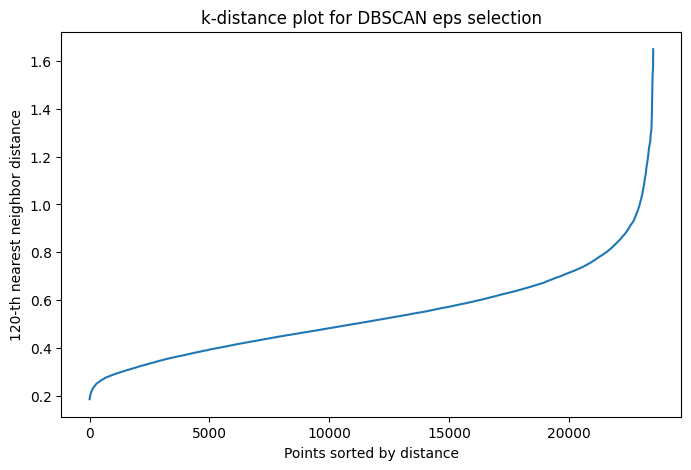

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np

k = 120
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(embed_70d)
distances, indices = neighbors_fit.kneighbors(embed_70d)

# distance to kth nearest neighbor
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(8,5))
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-th nearest neighbor distance")
plt.title("k-distance plot for DBSCAN eps selection")
plt.show()


In [22]:
dbscan = DBSCAN(
    eps=0.9,
    min_samples=120
)

dbscan_labels = dbscan.fit_predict(embed_70d)

df["dbscan_cluster2"] = dbscan_labels

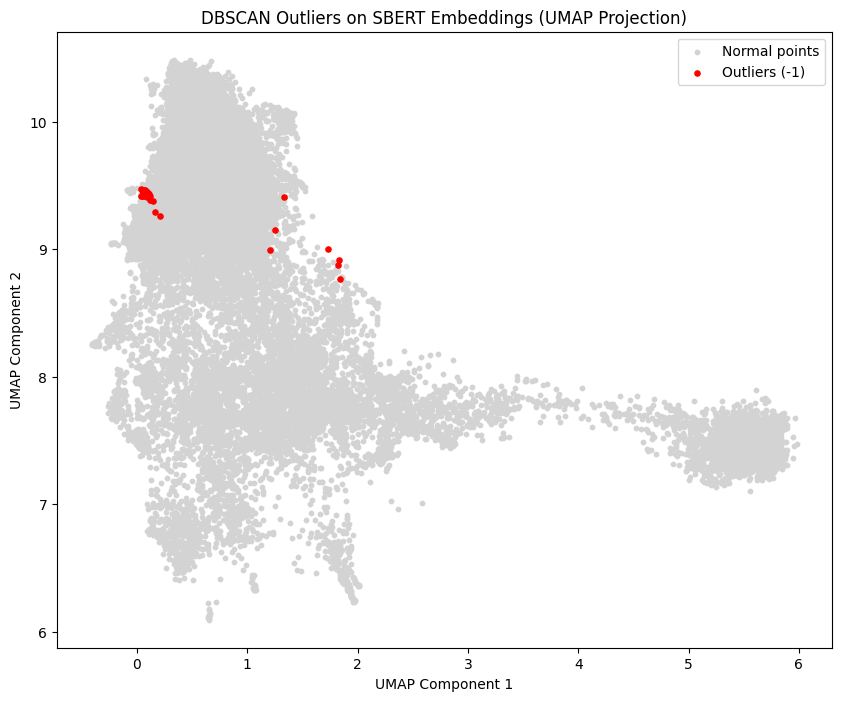

In [ ]:


plt.figure(figsize=(10, 8))

# Non-outliers
non_outliers = dbscan_labels != -1
plt.scatter(
    embed_70d[non_outliers, 0],
    embed_70d[non_outliers, 1],
    c="lightgray",
    s=10,
    label="Normal points"
)

# Outliers highlighted
outliers = dbscan_labels == -1
plt.scatter(
    embed_70d[outliers, 0],
    embed_70d[outliers, 1],
    c="red",
    s=14,
    label="Outliers (-1)"
)

plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title("DBSCAN Outliers on SBERT Embeddings (UMAP Projection)")
plt.legend()
plt.show()




In [ ]:
outliers = df[df["dbscan_cluster2"] == -1]
outliers["movie title"].head(10)

4447                       Deadly Games
8061                  The King's Speech
9676                   The Santa Clause
10180                 A Christmas Carol
10298                           Krampus
10665            Miracle on 34th Street
10960            A Boy Called Christmas
14175                  Arthur Christmas
14906                            Digger
15034    The Man Who Invented Christmas
Name: movie title, dtype: object

In [23]:
# Identify outlier indices
outlier_indices = df[df["dbscan_cluster2"] == -1].index

print("Removing", len(outlier_indices), "outliers")

# 1) Drop outliers from dataframe
df_clean = df.drop(index=outlier_indices).reset_index(drop=True)

embeddings_clean = np.delete(embed_70d, outlier_indices, axis=0)



Removing 44 outliers


In [27]:
from sklearn.mixture import GaussianMixture

bic_scores = []
aic_scores = []
k_range = range(1,21) 

for k in k_range:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=42
    )
    gmm.fit(embeddings_clean)
    bic_scores.append(gmm.bic(embeddings_clean))
    aic_scores.append(gmm.aic(embeddings_clean))


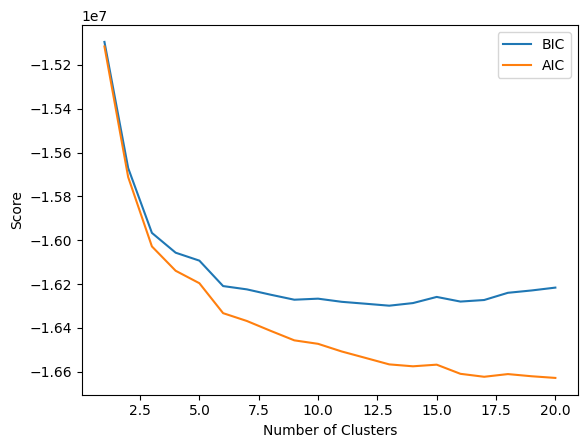

In [ ]:
plt.plot(k_range, bic_scores, label="BIC")
plt.plot(k_range, aic_scores, label="AIC")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.legend()
plt.show()


In [28]:
optimal_k = 12

gmm = GaussianMixture(
    n_components=optimal_k,
    covariance_type="full",
    random_state=42
)

gmm_labels = gmm.fit_predict(embeddings_clean)


In [29]:

df_clean["gmm_cluster2"] = gmm_labels
gmm_probs = gmm.predict_proba(embeddings_clean)

for cluster_id in range(optimal_k):
    print(f"\nCluster {cluster_id}")
    sample_titles = df_clean[df_clean["gmm_cluster2"] == cluster_id]["movie title"].head(20)
    print(sample_titles.tolist())




Cluster 0
['Flash Gordon', 'Friday Night Lights', 'Gleaming the Cube', 'Only You', 'Rollerball', 'The Program', 'The Fan', 'D3: The Mighty Ducks', 'Silent Night', 'East of the Mountains', 'Taxi 3', 'Catfight', 'Gymkata', 'Fantasy Football', 'The Traveler', 'Santa Jaws', 'Grey Eyes', "A Warrior's Heart", 'Skate God', 'Crossover']

Cluster 1
['Lightyear', 'Doctor Strange in the Multiverse of Madness', 'The Batman', 'Spider-Man: No Way Home', 'Star Wars', 'Avengers: Endgame', 'Star Wars: Episode I - The Phantom Menace', 'The Dark Knight', 'Moonfall', 'Star Wars: Episode III - Revenge of the Sith', 'Star Wars: Episode IX - The Rise of Skywalker', 'Venom: Let There Be Carnage', 'The Suicide Squad', 'Avengers: Infinity War', 'Star Wars: Episode II - Attack of the Clones', 'Aquaman and the Lost Kingdom', 'Star Wars: Episode VI - Return of the Jedi', 'The Amazing Spider-Man', 'Watchmen', 'Black Widow']

Cluster 2
['Vikram', 'Samrat Prithviraj', 'Major', 'K.G.F: Chapter 2', 'Brahmastra Part On

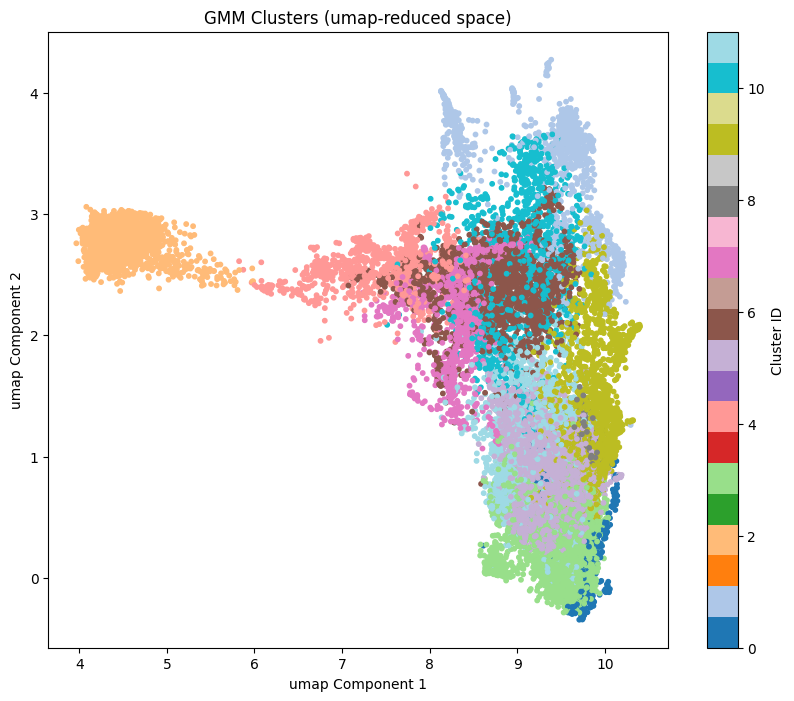

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(
    embeddings_clean[:, 0],
    embeddings_clean[:, 1],
    c=df_clean["gmm_cluster2"],
    cmap="tab20",
    s=10
)

plt.xlabel("umap Component 1")
plt.ylabel("umap Component 2")
plt.title("GMM Clusters (umap-reduced space)")
plt.colorbar(label="Cluster ID")
plt.show()


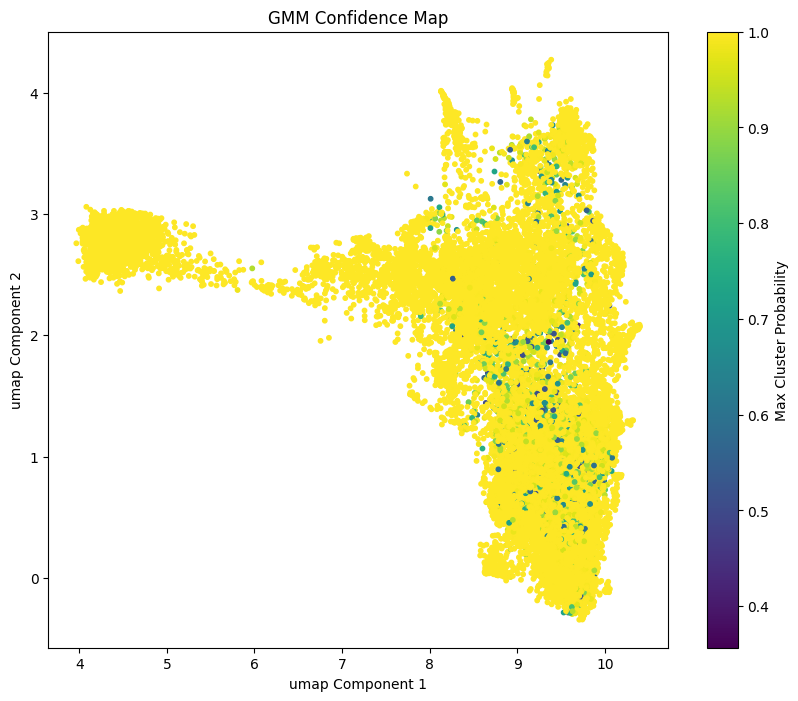

In [33]:
max_probs = gmm.predict_proba(embeddings_clean).max(axis=1)

plt.figure(figsize=(10, 8))
plt.scatter(
    embeddings_clean[:, 0],
    embeddings_clean[:, 1],
    c=max_probs,
    cmap="viridis",
    s=10
)

plt.xlabel("umap Component 1")
plt.ylabel("umap Component 2")
plt.title("GMM Confidence Map")
plt.colorbar(label="Max Cluster Probability")
plt.show()


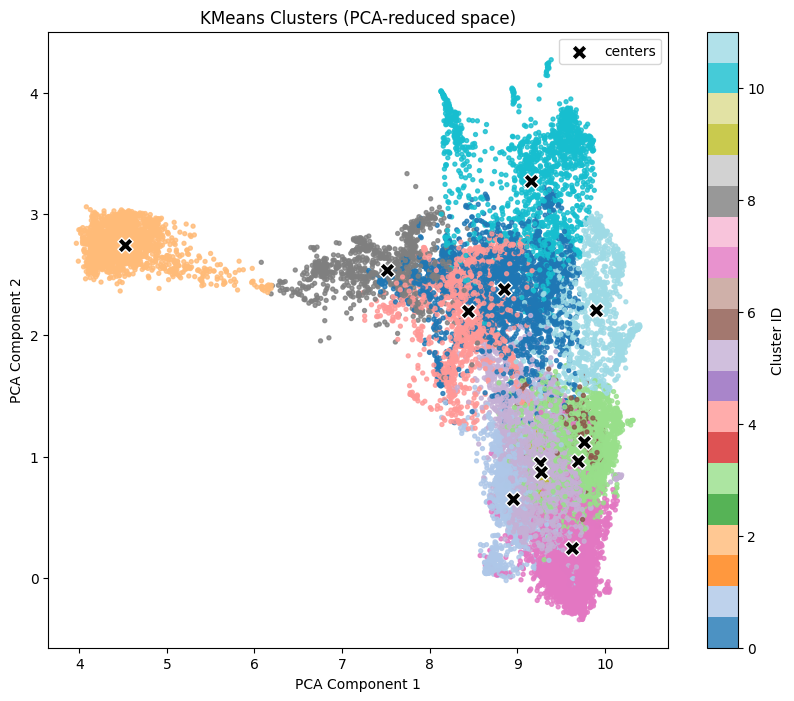

In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.metrics.cluster import contingency_matrix
import pandas as pd
import numpy as np

# Use same number of clusters as GMM for fair comparison
n_clusters = optimal_k  # uses existing variable

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(embeddings_clean)

# attach to dataframe
df_clean["kmeans_cluster2"] = kmeans_labels

plt.figure(figsize=(10, 8))
sc = plt.scatter(
    embeddings_clean[:, 0],
    embeddings_clean[:, 1],
    c=df_clean["kmeans_cluster2"],
    cmap="tab20",
    s=8,
    alpha=0.8
)

# Plot KMeans centers (same PCA space)
if hasattr(kmeans, "cluster_centers_"):
    centers = kmeans.cluster_centers_
    plt.scatter(
        centers[:, 0],
        centers[:, 1],
        c="black",
        s=120,
        marker="X",
        edgecolor="white",
        linewidth=1,
        label="centers"
    )

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("KMeans Clusters (PCA-reduced space)")
plt.colorbar(sc, label="Cluster ID")
plt.legend()
plt.show()

In [35]:
df_clean["kmeans_cluster"] = kmeans_labels

for cluster_id in range(n_clusters):
    print(f"\nCluster {cluster_id}")
    sample_titles = df_clean[df_clean["kmeans_cluster"] == cluster_id]["movie title"].head(20)
    print(sample_titles.tolist())




Cluster 0
['Jurassic World Dominion', 'Black Adam', 'The Northman', 'Thor: Love and Thunder', 'Fantastic Beasts: The Secrets of Dumbledore', 'Jurassic Park', 'Jurassic World', 'Jurassic World: Fallen Kingdom', 'Sonic the Hedgehog 2', 'The Lost World: Jurassic Park', 'Jurassic Park III', 'Pirates of the Caribbean: The Curse of the Black Pearl', 'Aquaman', 'Thor: Ragnarok', 'The Last Duel', 'Pirates of the Caribbean: Dead Men Tell No Tales', 'Sonic the Hedgehog', 'The Lord of the Rings: The Fellowship of the Ring', 'The Hunger Games: The Ballad of Songbirds and Snakes', 'The Hunger Games']

Cluster 1
['The Unbearable Weight of Massive Talent', 'Sicario', 'The Tourist', 'Inferno', 'Man on Fire', 'Revenge', 'Sicario: Day of the Soldado', 'The Saint', 'Romancing the Stone', 'Desperado', 'The Guardian', 'Sweet Girl', 'There Are No Saints', 'The Equalizer 2', 'Once Upon a Time in Mexico', 'The Italian Job', 'The Man in the Iron Mask', 'Machete Kills', '2 Guns', 'Spy Kids 3: Game Over']

Clus

# Recommend GMM

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_movies(
    movie_title,
    df_clean,
    embeddings,
    top_n=10
):
    # 1 — Find movie index safely
    matches = df_clean.index[df_clean["movie title"].str.lower() == movie_title.lower()]
    if len(matches) == 0:
        raise ValueError("Movie title not found in dataset.")
    
    idx = matches[0]

    # 2 — Check DBSCAN outlier label
    movie_dbscan_label = df_clean.loc[idx, "dbscan_cluster2"]

    if movie_dbscan_label == -1:
        # The movie itself is an outlier → no meaningful cluster
        # Fallback: compute similarity across NON-outliers only
        print("Note: Movie is an outlier in DBSCAN → using global similarity among non-outliers.")

        valid_indices = df_clean.index[df_clean["dbscan_cluster2"] != -1].to_numpy()

        similarities = cosine_similarity(
            embeddings[idx],
            embeddings[valid_indices]
        ).flatten()

        top_positions = similarities.argsort()[::-1][1:top_n+1]
        top_indices = valid_indices[top_positions]

        return df_clean.loc[top_indices, ["movie title", "Generes", "Top 5 Casts", "Director"]]

    # 3 — Otherwise proceed normally (GMM cluster-based)
    cluster_id = df_clean.loc[idx, "gmm_cluster2"]

    # Candidates = Same GMM cluster AND not DBSCAN outliers
    candidate_indices = df_clean.index[
        (df_clean["gmm_cluster2"] == cluster_id) &
        (df_clean["dbscan_cluster2"] != -1)
    ].to_numpy()

    # 4 — Compute similarity
    similarities = cosine_similarity(
        embeddings[idx].reshape(1,-1),
        embeddings[candidate_indices]
    ).flatten()

    # 5 — Rank top movies
    top_positions = similarities.argsort()[::-1][1:top_n+1]
    top_indices = candidate_indices[top_positions]


    return df_clean.loc[top_indices, ["movie title", "Generes", "Top 5 Casts", "Director"]]


In [45]:
recommend_movies(
    "Spider-Man",
    df_clean,
    embeddings,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
77,The Amazing Spider-Man,"['Action', 'Adventure', 'Sci-Fi']","['Alvin Sargent', 'Steve Kloves', 'Andrew Garf...",Marc Webb
320,Spider-Man 2,"['Action', 'Adventure', 'Sci-Fi']","['Steve Ditko', 'Alfred Gough', 'Tobey Maguire...",Sam Raimi
2828,Spider-Man 4: Fan Film,"['Action', 'Adventure', 'Drama']","['Bryn Clayton Jones', 'William McCarthy', 'Br...",Erik Franklin
108,Spider-Man: Homecoming,"['Action', 'Adventure', 'Sci-Fi']","['John Francis Daley', 'Jon Watts', 'Tom Holla...",Jon Watts
164,Spider-Man 3,"['Action', 'Adventure', 'Sci-Fi']","['Ivan Raimi', 'Alvin Sargent', 'Tobey Maguire...",Sam Raimi
2039,Spider-Man: Beyond the Spider-Verse,"['Animation', 'Action', 'Adventure']","['Justin K. Thompson', 'Dave Callaham', 'Phil ...",Joaquim Dos Santos
120,Spider-Man: Into the Spider-Verse,"['Animation', 'Action', 'Adventure']","['Rodney Rothman', 'Phil Lord', 'Rodney Rothma...",Bob Persichetti
195,Spider-Man: Across the Spider-Verse,"['Animation', 'Action', 'Adventure']","['Justin K. Thompson', 'Phil Lord', 'Christoph...",Joaquim Dos Santos
809,Madame Web,"['Action', 'Adventure', 'Sci-Fi']","['Matt Sazama', 'Burk Sharpless', 'Dakota John...",S.J. Clarkson
215,The Incredibles,"['Animation', 'Action', 'Adventure']","['Craig T. Nelson', 'Samuel L. Jackson', 'Holl...",Brad Bird


In [46]:

recommend_movies(
    "The dark knight",
    df_clean,
    embeddings,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
193,Batman,"['Action', 'Adventure']","['Sam Hamm', 'Warren Skaaren', 'Michael Keaton...",Tim Burton
133,The Dark Knight Rises,"['Action', 'Drama']","['Christopher Nolan', 'David S. Goyer', 'Chris...",Christopher Nolan
1284,Batman: The Killing Joke,"['Animation', 'Action', 'Crime']","['Brian Bolland', 'Bob Kane', 'Kevin Conroy', ...",Sam Liu
3093,Batman and Robin,"['Action', 'Adventure', 'Family']","['George H. Plympton', 'Joseph F. Poland', 'Ro...",Spencer Gordon Bennet
122,Batman Begins,"['Action', 'Crime', 'Drama']","['David S. Goyer', 'Christopher Nolan', 'Chris...",Christopher Nolan
157,Batman Forever,"['Action', 'Adventure']","['Lee Batchler', 'Janet Scott Batchler', 'Val ...",Joel Schumacher
2154,Batman and Harley Quinn,"['Animation', 'Action', 'Adventure']","['James Krieg', 'Bob Kane', 'Kevin Conroy', 'M...",Sam Liu
1304,"Batman: The Long Halloween, Part One","['Animation', 'Action', 'Crime']","['Tim Sale', 'Tim Sheridan', 'Jensen Ackles', ...",Chris Palmer
1833,Gotham City Sirens,"['Action', 'Adventure', 'Comedy']","['Bruce Timm', 'Margot Robbie', 'Paul Dini', '...",Paul Dini
263,Batman Returns,"['Action', 'Crime', 'Fantasy']","['Daniel Waters', 'Sam Hamm', 'Michael Keaton'...",Tim Burton


In [47]:
recommend_movies(
    "no time to die",
    df_clean,
    embeddings,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
244,Quantum of Solace,"['Action', 'Adventure', 'Thriller']","['Neal Purvis', 'Robert Wade', 'Daniel Craig',...",Marc Forster
591,Licence to Kill,"['Action', 'Adventure', 'Thriller']","['Richard Maibaum', 'Ian Fleming', 'Timothy Da...",John Glen
149,Skyfall,"['Action', 'Adventure', 'Thriller']","['Robert Wade', 'John Logan', 'Daniel Craig', ...",Sam Mendes
296,GoldenEye,"['Action', 'Adventure', 'Thriller']","['Michael France', 'Jeffrey Caine', 'Pierce Br...",Martin Campbell
403,Tomorrow Never Dies,"['Action', 'Adventure', 'Thriller']","['Ian Fleming', 'Pierce Brosnan', 'Jonathan Pr...",Roger Spottiswoode
564,Live and Let Die,"['Action', 'Adventure', 'Thriller']","['Ian Fleming', 'Roger Moore', 'Yaphet Kotto',...",Guy Hamilton
670,The Living Daylights,"['Action', 'Adventure', 'Thriller']","['Michael G. Wilson', 'Ian Fleming', 'Timothy ...",John Glen
593,The Spy Who Loved Me,"['Action', 'Adventure', 'Thriller']","['Richard Maibaum', 'Ian Fleming', 'Roger Moor...",Lewis Gilbert
612,The Man with the Golden Gun,"['Action', 'Adventure', 'Thriller']","['Tom Mankiewicz', 'Ian Fleming', 'Roger Moore...",Guy Hamilton
570,From Russia with Love,"['Action', 'Adventure', 'Thriller']","['Johanna Harwood', 'Ian Fleming', 'Sean Conne...",Terence Young


In [48]:
recommend_movies(
    "se7en",
    df_clean,
    embeddings,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
17832,Vampire in Brooklyn,"['Comedy', 'Fantasy', 'Horror']","['Vernon Lynch', 'Charlie Murphy', 'Eddie Murp...",Wes Craven
20044,Meeting Evil,"['Crime', 'Drama', 'Mystery']","['Chris Fisher', 'Luke Wilson', 'Samuel L. Jac...",Chris Fisher
22113,Hidden Truth,['Thriller'],"['Sarah Lind', 'Shawn Christian', 'Diana Hoppe...",Steven R. Monroe
10242,Black Water Transit,"['Crime', 'Drama']","['Carsten Stroud', 'Karl Urban', 'Brittany Sno...",Tony Kaye
21108,You Kill Me,"['Comedy', 'Crime', 'Romance']","['Stephen McFeely', 'Ben Kingsley', 'TÃ©a Leon...",John Dahl
20695,13 Sins,"['Horror', 'Thriller']","['Daniel Stamm', 'Chookiat Sakveerakul', 'Mark...",Daniel Stamm
12587,La polizia brancola nel buio,"['Crime', 'Mystery', 'Sci-Fi']","['Joseph Arkim', 'Francisco CortÃ©z', 'Richard...",Helia Colombo
20050,Judas Kiss,"['Crime', 'Drama', 'Thriller']","['Deanna Fuller', 'Alan Rickman', 'Emma Thomps...",Sebastian Gutierrez
21378,Cop,"['Crime', 'Drama', 'Mystery']","['James B. Harris', 'James Woods', 'Lesley Ann...",James B. Harris
17330,So I Married an Axe Murderer,"['Comedy', 'Romance']","['Mike Myers', 'Nancy Travis', 'Anthony LaPagl...",Thomas Schlamme


In [49]:
recommend_movies(
    "Harry Potter and the Order of the Phoenix",
    df_clean,
    embeddings,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
15345,Harry Potter and the Chamber of Secrets,"['Adventure', 'Family', 'Fantasy']","['Steve Kloves', 'Daniel Radcliffe', 'Rupert G...",Chris Columbus
10,Fantastic Beasts: The Secrets of Dumbledore,"['Action', 'Adventure', 'Fantasy']","['Steve Kloves', 'Eddie Redmayne', 'Jude Law',...",David Yates
15338,Toy Story 2,"['Animation', 'Adventure', 'Comedy']","['Lee Unkrich', 'John Lasseter', 'Pete Docter'...",John Lasseter
330,Harry Potter and the Half-Blood Prince,"['Action', 'Adventure', 'Family']","['J.K. Rowling', 'Daniel Radcliffe', 'Emma Wat...",David Yates
3539,Harry Potter and the Cursed Child: London Show,"['Action', 'Adventure', 'Fantasy']","['Jack Thorne', 'John Tiffany', 'Jeremy Ang Jo...",John Tiffany
210,The Lord of the Rings: The Two Towers,"['Action', 'Adventure', 'Drama']","['Fran Walsh', 'Philippa Boyens', 'Elijah Wood...",Peter Jackson
854,The Sorcerer's Apprentice,"['Action', 'Adventure', 'Family']","['Mark Rosenthal', 'Matt Lopez', 'Nicolas Cage...",Jon Turteltaub
4263,King Arthur and the Knights of the Round Table,"['Action', 'Adventure', 'Crime']","['Sara Malakul Lane', ""Eoin O'Brien"", 'Alexand...",Jared Cohn
136,The Lord of the Rings: The Return of the King,"['Action', 'Adventure', 'Drama']","['Fran Walsh', 'Philippa Boyens', 'Elijah Wood...",Peter Jackson
665,The Hunger Games: Mockingjay - Part 1,"['Action', 'Adventure', 'Sci-Fi']","['Danny Strong', 'Suzanne Collins', 'Jennifer ...",Francis Lawrence


In [50]:
recommend_movies(
    "the avengers",
    df_clean,
    embeddings,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
220,Avengers: Age of Ultron,"['Action', 'Adventure', 'Sci-Fi']","['Stan Lee', 'Jack Kirby', 'Robert Downey Jr.'...",Joss Whedon
64,Avengers: Infinity War,"['Action', 'Adventure', 'Sci-Fi']","['Christopher Markus', 'Stephen McFeely', 'Sta...",Anthony Russo
167,Venom,"['Action', 'Adventure', 'Sci-Fi']","['Scott Rosenberg', 'Kelly Marcel', 'Tom Hardy...",Ruben Fleischer
342,Batman v Superman: Dawn of Justice,"['Action', 'Adventure', 'Sci-Fi']","['David S. Goyer', 'Bob Kane', 'Ben Affleck', ...",Zack Snyder
132,Suicide Squad,"['Action', 'Adventure', 'Fantasy']","['John Ostrander', 'Will Smith', 'Jared Leto',...",David Ayer
150,Iron Man,"['Action', 'Adventure', 'Sci-Fi']","['Hawk Ostby', 'Art Marcum', 'Robert Downey Jr...",Jon Favreau
164,Spider-Man 3,"['Action', 'Adventure', 'Sci-Fi']","['Ivan Raimi', 'Alvin Sargent', 'Tobey Maguire...",Sam Raimi
32,Avengers: Endgame,"['Action', 'Adventure', 'Drama']","['Christopher Markus', 'Stephen McFeely', 'Sta...",Anthony Russo
110,Captain Marvel,"['Action', 'Adventure', 'Sci-Fi']","['Anna Boden', 'Ryan Fleck', 'Geneva Robertson...",Anna Boden
171,Captain America: The First Avenger,"['Action', 'Adventure', 'Sci-Fi']","['Stephen McFeely', 'Joe Simon', 'Chris Evans'...",Joe Johnston


In [51]:
recommend_movies(
    "mission: impossible",
    df_clean,
    embeddings,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
645,Jason Bourne,"['Action', 'Thriller']","['Christopher Rouse', 'Robert Ludlum', 'Matt D...",Paul Greengrass
1754,Gator,"['Action', 'Crime', 'Drama']","['Roderick Taylor', 'Burt Reynolds', 'Jack Wes...",Burt Reynolds
1892,The Double,"['Action', 'Crime', 'Drama']","['Derek Haas', 'Richard Gere', 'Topher Grace',...",Michael Brandt
2805,Ballistic: Ecks vs. Sever,"['Action', 'Crime', 'Mystery']","['Antonio Banderas', 'Lucy Liu', 'Talisa Soto'...",Wych Kaosayananda
57,Mission: Impossible - Ghost Protocol,"['Action', 'Adventure', 'Thriller']","['Josh Appelbaum', 'AndrÃ© Nemec', 'Tom Cruise...",Brad Bird
1506,The Recruit,"['Action', 'Thriller']","['Kurt Wimmer', 'Mitch Glazer', 'Al Pacino', '...",Roger Donaldson
901,Salt,"['Action', 'Thriller']","['Angelina Jolie', 'Liev Schreiber', 'Chiwetel...",Phillip Noyce
117,Kingsman: The Secret Service,"['Action', 'Adventure', 'Comedy']","['Matthew Vaughn', 'Mark Millar', 'Colin Firth...",Matthew Vaughn
20540,The Thirteenth Floor,"['Mystery', 'Sci-Fi', 'Thriller']","['Josef Rusnak', 'Ravel Centeno-Rodriguez', 'C...",Josef Rusnak
573,True Lies,"['Action', 'Comedy', 'Thriller']","['Simon MichaÃ«l', 'Didier Kaminka', 'Arnold S...",James Cameron


# recommend kmeans

In [52]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_movies(
    movie_title,
    df_clean,
    embeddings,
    top_n=10
):
    # 1 — Find movie index safely
    matches = df_clean.index[df_clean["movie title"].str.lower() == movie_title.lower()]
    if len(matches) == 0:
        raise ValueError("Movie title not found in dataset.")
    
    idx = matches[0]

    # 2 — Check DBSCAN outlier label
    movie_dbscan_label = df_clean.loc[idx, "dbscan_cluster2"]

    if movie_dbscan_label == -1:
        # The movie itself is an outlier → no meaningful cluster
        # Fallback: compute similarity across NON-outliers only
        print("Note: Movie is an outlier in DBSCAN → using global similarity among non-outliers.")

        valid_indices = df_clean.index[df_clean["dbscan_cluster2"] != -1].to_numpy()

        similarities = cosine_similarity(
            embeddings[idx],
            embeddings[valid_indices]
        ).flatten()

        top_positions = similarities.argsort()[::-1][1:top_n+1]
        top_indices = valid_indices[top_positions]

        return df_clean.loc[top_indices, ["movie title", "Generes", "Top 5 Casts", "Director"]]

    # 3 — Otherwise proceed normally (GMM cluster-based)
    cluster_id = df_clean.loc[idx, "kmeans_cluster2"]

    # Candidates = Same GMM cluster AND not DBSCAN outliers
    candidate_indices = df_clean.index[
        (df_clean["kmeans_cluster2"] == cluster_id) &
        (df_clean["dbscan_cluster2"] != -1)
    ].to_numpy()

    # 4 — Compute similarity
    similarities = cosine_similarity(
        embeddings[idx].reshape(1,-1),
        embeddings[candidate_indices]
    ).flatten()

    # 5 — Rank top movies
    top_positions = similarities.argsort()[::-1][1:top_n+1]
    top_indices = candidate_indices[top_positions]


    return df_clean.loc[top_indices, ["movie title", "Generes", "Top 5 Casts", "Director"]]


In [53]:
recommend_movies(
    "mission: impossible",
    df_clean,
    embeddings,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
645,Jason Bourne,"['Action', 'Thriller']","['Christopher Rouse', 'Robert Ludlum', 'Matt D...",Paul Greengrass
1892,The Double,"['Action', 'Crime', 'Drama']","['Derek Haas', 'Richard Gere', 'Topher Grace',...",Michael Brandt
2805,Ballistic: Ecks vs. Sever,"['Action', 'Crime', 'Mystery']","['Antonio Banderas', 'Lucy Liu', 'Talisa Soto'...",Wych Kaosayananda
57,Mission: Impossible - Ghost Protocol,"['Action', 'Adventure', 'Thriller']","['Josh Appelbaum', 'AndrÃ© Nemec', 'Tom Cruise...",Brad Bird
1506,The Recruit,"['Action', 'Thriller']","['Kurt Wimmer', 'Mitch Glazer', 'Al Pacino', '...",Roger Donaldson
901,Salt,"['Action', 'Thriller']","['Angelina Jolie', 'Liev Schreiber', 'Chiwetel...",Phillip Noyce
117,Kingsman: The Secret Service,"['Action', 'Adventure', 'Comedy']","['Matthew Vaughn', 'Mark Millar', 'Colin Firth...",Matthew Vaughn
573,True Lies,"['Action', 'Comedy', 'Thriller']","['Simon MichaÃ«l', 'Didier Kaminka', 'Arnold S...",James Cameron
1890,Legacy of Lies,"['Action', 'Thriller']","['Scott Adkins', 'Anna Butkevich', 'Yuliia Sob...",Adrian Bol
2877,Fast and Loose,"['Action', 'Crime', 'Thriller']","['Will Smith', 'Erich Hoeber', 'Jon Hoeber', '...",Erich Hoeber


In [54]:
recommend_movies(
    "the avengers",
    df_clean,
    embeddings,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
220,Avengers: Age of Ultron,"['Action', 'Adventure', 'Sci-Fi']","['Stan Lee', 'Jack Kirby', 'Robert Downey Jr.'...",Joss Whedon
64,Avengers: Infinity War,"['Action', 'Adventure', 'Sci-Fi']","['Christopher Markus', 'Stephen McFeely', 'Sta...",Anthony Russo
167,Venom,"['Action', 'Adventure', 'Sci-Fi']","['Scott Rosenberg', 'Kelly Marcel', 'Tom Hardy...",Ruben Fleischer
342,Batman v Superman: Dawn of Justice,"['Action', 'Adventure', 'Sci-Fi']","['David S. Goyer', 'Bob Kane', 'Ben Affleck', ...",Zack Snyder
132,Suicide Squad,"['Action', 'Adventure', 'Fantasy']","['John Ostrander', 'Will Smith', 'Jared Leto',...",David Ayer
150,Iron Man,"['Action', 'Adventure', 'Sci-Fi']","['Hawk Ostby', 'Art Marcum', 'Robert Downey Jr...",Jon Favreau
1617,Heavy Metal 2000,"['Animation', 'Action', 'Adventure']","['Kevin Eastman', 'Simon Bisley', 'Eric Talbot...",Michael Coldewey
164,Spider-Man 3,"['Action', 'Adventure', 'Sci-Fi']","['Ivan Raimi', 'Alvin Sargent', 'Tobey Maguire...",Sam Raimi
32,Avengers: Endgame,"['Action', 'Adventure', 'Drama']","['Christopher Markus', 'Stephen McFeely', 'Sta...",Anthony Russo
110,Captain Marvel,"['Action', 'Adventure', 'Sci-Fi']","['Anna Boden', 'Ryan Fleck', 'Geneva Robertson...",Anna Boden


In [55]:
recommend_movies(
    "Spider-man",
    df_clean,
    embeddings,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
77,The Amazing Spider-Man,"['Action', 'Adventure', 'Sci-Fi']","['Alvin Sargent', 'Steve Kloves', 'Andrew Garf...",Marc Webb
320,Spider-Man 2,"['Action', 'Adventure', 'Sci-Fi']","['Steve Ditko', 'Alfred Gough', 'Tobey Maguire...",Sam Raimi
2828,Spider-Man 4: Fan Film,"['Action', 'Adventure', 'Drama']","['Bryn Clayton Jones', 'William McCarthy', 'Br...",Erik Franklin
108,Spider-Man: Homecoming,"['Action', 'Adventure', 'Sci-Fi']","['John Francis Daley', 'Jon Watts', 'Tom Holla...",Jon Watts
164,Spider-Man 3,"['Action', 'Adventure', 'Sci-Fi']","['Ivan Raimi', 'Alvin Sargent', 'Tobey Maguire...",Sam Raimi
2039,Spider-Man: Beyond the Spider-Verse,"['Animation', 'Action', 'Adventure']","['Justin K. Thompson', 'Dave Callaham', 'Phil ...",Joaquim Dos Santos
120,Spider-Man: Into the Spider-Verse,"['Animation', 'Action', 'Adventure']","['Rodney Rothman', 'Phil Lord', 'Rodney Rothma...",Bob Persichetti
195,Spider-Man: Across the Spider-Verse,"['Animation', 'Action', 'Adventure']","['Justin K. Thompson', 'Phil Lord', 'Christoph...",Joaquim Dos Santos
809,Madame Web,"['Action', 'Adventure', 'Sci-Fi']","['Matt Sazama', 'Burk Sharpless', 'Dakota John...",S.J. Clarkson
215,The Incredibles,"['Animation', 'Action', 'Adventure']","['Craig T. Nelson', 'Samuel L. Jackson', 'Holl...",Brad Bird


In [56]:
recommend_movies(
    "Harry Potter and the Order of the Phoenix",
    df_clean,
    embeddings,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
15345,Harry Potter and the Chamber of Secrets,"['Adventure', 'Family', 'Fantasy']","['Steve Kloves', 'Daniel Radcliffe', 'Rupert G...",Chris Columbus
10,Fantastic Beasts: The Secrets of Dumbledore,"['Action', 'Adventure', 'Fantasy']","['Steve Kloves', 'Eddie Redmayne', 'Jude Law',...",David Yates
15338,Toy Story 2,"['Animation', 'Adventure', 'Comedy']","['Lee Unkrich', 'John Lasseter', 'Pete Docter'...",John Lasseter
330,Harry Potter and the Half-Blood Prince,"['Action', 'Adventure', 'Family']","['J.K. Rowling', 'Daniel Radcliffe', 'Emma Wat...",David Yates
3539,Harry Potter and the Cursed Child: London Show,"['Action', 'Adventure', 'Fantasy']","['Jack Thorne', 'John Tiffany', 'Jeremy Ang Jo...",John Tiffany
210,The Lord of the Rings: The Two Towers,"['Action', 'Adventure', 'Drama']","['Fran Walsh', 'Philippa Boyens', 'Elijah Wood...",Peter Jackson
854,The Sorcerer's Apprentice,"['Action', 'Adventure', 'Family']","['Mark Rosenthal', 'Matt Lopez', 'Nicolas Cage...",Jon Turteltaub
4263,King Arthur and the Knights of the Round Table,"['Action', 'Adventure', 'Crime']","['Sara Malakul Lane', ""Eoin O'Brien"", 'Alexand...",Jared Cohn
136,The Lord of the Rings: The Return of the King,"['Action', 'Adventure', 'Drama']","['Fran Walsh', 'Philippa Boyens', 'Elijah Wood...",Peter Jackson
665,The Hunger Games: Mockingjay - Part 1,"['Action', 'Adventure', 'Sci-Fi']","['Danny Strong', 'Suzanne Collins', 'Jennifer ...",Francis Lawrence


# Model Comparison and Evaluation

In [57]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import pandas as pd
import numpy as np

# Prepare comparison data structure
comparison_results = []

In [58]:
# Check if all required variables exist before running comparison
required_vars = {
    'df_clean_tfidf': 'Created in cell 28 - TF-IDF cleaned dataframe',
    'pca_clean': 'Created in cell 28 - PCA features after outlier removal',
    'tfidf_clean': 'Created in cell 28 - TF-IDF matrix after outlier removal',
    'df_clean': 'Created in cell 66 - SBERT cleaned dataframe',
    'embeddings_clean': 'Created in cell 66 - SBERT embeddings after outlier removal'
}

missing_vars = []
for var_name, description in required_vars.items():
    if var_name not in globals():
        missing_vars.append(f"❌ {var_name}: {description}")
    else:
        print(f"✅ {var_name}: Found")

if missing_vars:
    print("\n" + "="*80)
    print("⚠️  MISSING REQUIRED VARIABLES:")
    print("="*80)
    for msg in missing_vars:
        print(msg)
    print("\n" + "="*80)
    print("📋 TO FIX THIS:")
    print("="*80)
    print("1. Click 'Restart' button at the top to restart the kernel")
    print("2. Run 'Run All' or execute cells 1-28 for TF-IDF models")
    print("3. Execute cells 58-66 for SBERT models")
    print("4. Then run the comparison cells (this section)")
    print("="*80)
    raise RuntimeError("Missing required variables. Please run prerequisite cells first!")
else:
    print("\n✅ All required variables exist! You can proceed with the comparison.")


✅ df_clean_tfidf: Found
✅ pca_clean: Found
✅ tfidf_clean: Found
✅ df_clean: Found
✅ embeddings_clean: Found

✅ All required variables exist! You can proceed with the comparison.


## 1. TF-IDF Based Models (PCA Reduced)

In [59]:
# Evaluate DBSCAN (TF-IDF)
dbscan_tfidf_labels = df_clean_tfidf["dbscan_cluster"].values
valid_dbscan_tfidf = dbscan_tfidf_labels != -1

if valid_dbscan_tfidf.sum() > 1 and len(np.unique(dbscan_tfidf_labels[valid_dbscan_tfidf])) > 1:
    dbscan_tfidf_silhouette = silhouette_score(pca_clean[valid_dbscan_tfidf], 
                                                 dbscan_tfidf_labels[valid_dbscan_tfidf])
    dbscan_tfidf_davies = davies_bouldin_score(pca_clean[valid_dbscan_tfidf], 
                                                dbscan_tfidf_labels[valid_dbscan_tfidf])
    dbscan_tfidf_calinski = calinski_harabasz_score(pca_clean[valid_dbscan_tfidf], 
                                                     dbscan_tfidf_labels[valid_dbscan_tfidf])
else:
    dbscan_tfidf_silhouette = dbscan_tfidf_davies = dbscan_tfidf_calinski = np.nan

n_outliers_tfidf = (dbscan_tfidf_labels == -1).sum()
n_clusters_tfidf = len(np.unique(dbscan_tfidf_labels[valid_dbscan_tfidf]))

comparison_results.append({
    "Model": "DBSCAN (TF-IDF)",
    "Representation": "TF-IDF + PCA",
    "Silhouette Score": dbscan_tfidf_silhouette,
    "Davies-Bouldin Index": dbscan_tfidf_davies,
    "Calinski-Harabasz Index": dbscan_tfidf_calinski,
    "N Clusters": n_clusters_tfidf,
    "N Outliers": n_outliers_tfidf,
    "Total Samples": len(dbscan_tfidf_labels)
})

print(f"DBSCAN (TF-IDF) - Clusters: {n_clusters_tfidf}, Outliers: {n_outliers_tfidf}")
print(f"  Silhouette: {dbscan_tfidf_silhouette:.4f}")
print(f"  Davies-Bouldin: {dbscan_tfidf_davies:.4f}")
print(f"  Calinski-Harabasz: {dbscan_tfidf_calinski:.2f}")

DBSCAN (TF-IDF) - Clusters: 1, Outliers: 0
  Silhouette: nan
  Davies-Bouldin: nan
  Calinski-Harabasz: nan


In [65]:
# Evaluate GMM (TF-IDF)
gmm_tfidf_labels = df_clean_tfidf["gmm_cluster"].values
gmm_tfidf_silhouette = silhouette_score(pca_clean, gmm_tfidf_labels)
gmm_tfidf_davies = davies_bouldin_score(pca_clean, gmm_tfidf_labels)
gmm_tfidf_calinski = calinski_harabasz_score(pca_clean, gmm_tfidf_labels)

comparison_results.append({
    "Model": "GMM (TF-IDF)",
    "Representation": "TF-IDF + PCA",
    "Silhouette Score": gmm_tfidf_silhouette,
    "Davies-Bouldin Index": gmm_tfidf_davies,
    "Calinski-Harabasz Index": gmm_tfidf_calinski,
    "N Clusters": len(np.unique(gmm_tfidf_labels)),
    "N Outliers": 0,
    "Total Samples": len(gmm_tfidf_labels)
})

print(f"\nGMM (TF-IDF) - Clusters: {len(np.unique(gmm_tfidf_labels))}")
print(f"  Silhouette: {gmm_tfidf_silhouette:.4f}")
print(f"  Davies-Bouldin: {gmm_tfidf_davies:.4f}")
print(f"  Calinski-Harabasz: {gmm_tfidf_calinski:.2f}")


GMM (TF-IDF) - Clusters: 10
  Silhouette: -0.0458
  Davies-Bouldin: 6.6729
  Calinski-Harabasz: 205.28


In [66]:
# Evaluate KMeans (TF-IDF)
kmeans_tfidf_labels = df_clean_tfidf["kmeans_cluster"].values
kmeans_tfidf_silhouette = silhouette_score(pca_clean, kmeans_tfidf_labels)
kmeans_tfidf_davies = davies_bouldin_score(pca_clean, kmeans_tfidf_labels)
kmeans_tfidf_calinski = calinski_harabasz_score(pca_clean, kmeans_tfidf_labels)

comparison_results.append({
    "Model": "KMeans (TF-IDF)",
    "Representation": "TF-IDF + PCA",
    "Silhouette Score": kmeans_tfidf_silhouette,
    "Davies-Bouldin Index": kmeans_tfidf_davies,
    "Calinski-Harabasz Index": kmeans_tfidf_calinski,
    "N Clusters": len(np.unique(kmeans_tfidf_labels)),
    "N Outliers": 0,
    "Total Samples": len(kmeans_tfidf_labels)
})

print(f"\nKMeans (TF-IDF) - Clusters: {len(np.unique(kmeans_tfidf_labels))}")
print(f"  Silhouette: {kmeans_tfidf_silhouette:.4f}")
print(f"  Davies-Bouldin: {kmeans_tfidf_davies:.4f}")
print(f"  Calinski-Harabasz: {kmeans_tfidf_calinski:.2f}")


KMeans (TF-IDF) - Clusters: 10
  Silhouette: 0.0438
  Davies-Bouldin: 3.2537
  Calinski-Harabasz: 572.16


## 2. SBERT Embedding Based Models (UMAP Reduced)

In [67]:
# Evaluate DBSCAN (SBERT)
dbscan_sbert_labels = df_clean["dbscan_cluster2"].values
valid_dbscan_sbert = dbscan_sbert_labels != -1

if valid_dbscan_sbert.sum() > 1 and len(np.unique(dbscan_sbert_labels[valid_dbscan_sbert])) > 1:
    dbscan_sbert_silhouette = silhouette_score(embeddings_clean[valid_dbscan_sbert], 
                                                dbscan_sbert_labels[valid_dbscan_sbert])
    dbscan_sbert_davies = davies_bouldin_score(embeddings_clean[valid_dbscan_sbert], 
                                                dbscan_sbert_labels[valid_dbscan_sbert])
    dbscan_sbert_calinski = calinski_harabasz_score(embeddings_clean[valid_dbscan_sbert], 
                                                     dbscan_sbert_labels[valid_dbscan_sbert])
else:
    dbscan_sbert_silhouette = dbscan_sbert_davies = dbscan_sbert_calinski = np.nan

n_outliers_sbert = (dbscan_sbert_labels == -1).sum()
n_clusters_sbert = len(np.unique(dbscan_sbert_labels[valid_dbscan_sbert]))

comparison_results.append({
    "Model": "DBSCAN (SBERT)",
    "Representation": "SBERT + UMAP",
    "Silhouette Score": dbscan_sbert_silhouette,
    "Davies-Bouldin Index": dbscan_sbert_davies,
    "Calinski-Harabasz Index": dbscan_sbert_calinski,
    "N Clusters": n_clusters_sbert,
    "N Outliers": n_outliers_sbert,
    "Total Samples": len(dbscan_sbert_labels)
})

print(f"DBSCAN (SBERT) - Clusters: {n_clusters_sbert}, Outliers: {n_outliers_sbert}")
print(f"  Silhouette: {dbscan_sbert_silhouette:.4f}")
print(f"  Davies-Bouldin: {dbscan_sbert_davies:.4f}")
print(f"  Calinski-Harabasz: {dbscan_sbert_calinski:.2f}")

DBSCAN (SBERT) - Clusters: 1, Outliers: 0
  Silhouette: nan
  Davies-Bouldin: nan
  Calinski-Harabasz: nan


In [68]:
# Evaluate GMM (SBERT)
gmm_sbert_labels = df_clean["gmm_cluster2"].values
gmm_sbert_silhouette = silhouette_score(embeddings_clean, gmm_sbert_labels)
gmm_sbert_davies = davies_bouldin_score(embeddings_clean, gmm_sbert_labels)
gmm_sbert_calinski = calinski_harabasz_score(embeddings_clean, gmm_sbert_labels)

comparison_results.append({
    "Model": "GMM (SBERT)",
    "Representation": "SBERT + UMAP",
    "Silhouette Score": gmm_sbert_silhouette,
    "Davies-Bouldin Index": gmm_sbert_davies,
    "Calinski-Harabasz Index": gmm_sbert_calinski,
    "N Clusters": len(np.unique(gmm_sbert_labels)),
    "N Outliers": 0,
    "Total Samples": len(gmm_sbert_labels)
})

print(f"\nGMM (SBERT) - Clusters: {len(np.unique(gmm_sbert_labels))}")
print(f"  Silhouette: {gmm_sbert_silhouette:.4f}")
print(f"  Davies-Bouldin: {gmm_sbert_davies:.4f}")
print(f"  Calinski-Harabasz: {gmm_sbert_calinski:.2f}")


GMM (SBERT) - Clusters: 12
  Silhouette: 0.3045
  Davies-Bouldin: 1.3501
  Calinski-Harabasz: 9721.22


In [69]:
# Evaluate KMeans (SBERT)
kmeans_sbert_labels = df_clean["kmeans_cluster2"].values
kmeans_sbert_silhouette = silhouette_score(embeddings_clean, kmeans_sbert_labels)
kmeans_sbert_davies = davies_bouldin_score(embeddings_clean, kmeans_sbert_labels)
kmeans_sbert_calinski = calinski_harabasz_score(embeddings_clean, kmeans_sbert_labels)

comparison_results.append({
    "Model": "KMeans (SBERT)",
    "Representation": "SBERT + UMAP",
    "Silhouette Score": kmeans_sbert_silhouette,
    "Davies-Bouldin Index": kmeans_sbert_davies,
    "Calinski-Harabasz Index": kmeans_sbert_calinski,
    "N Clusters": len(np.unique(kmeans_sbert_labels)),
    "N Outliers": 0,
    "Total Samples": len(kmeans_sbert_labels)
})

print(f"\nKMeans (SBERT) - Clusters: {len(np.unique(kmeans_sbert_labels))}")
print(f"  Silhouette: {kmeans_sbert_silhouette:.4f}")
print(f"  Davies-Bouldin: {kmeans_sbert_davies:.4f}")
print(f"  Calinski-Harabasz: {kmeans_sbert_calinski:.2f}")


KMeans (SBERT) - Clusters: 12
  Silhouette: 0.3828
  Davies-Bouldin: 0.9900
  Calinski-Harabasz: 12656.28


## 3. Comprehensive Comparison Table

In [70]:
# Create comparison DataFrame
df_comparison = pd.DataFrame(comparison_results)

# Round numerical values for better display
df_comparison["Silhouette Score"] = df_comparison["Silhouette Score"].round(4)
df_comparison["Davies-Bouldin Index"] = df_comparison["Davies-Bouldin Index"].round(4)
df_comparison["Calinski-Harabasz Index"] = df_comparison["Calinski-Harabasz Index"].round(2)

print("\n" + "="*100)
print("MODEL PERFORMANCE COMPARISON")
print("="*100)
print("\nMetrics Interpretation:")
print("  • Silhouette Score: [-1, 1], higher is better (measures cluster cohesion)")
print("  • Davies-Bouldin Index: [0, ∞), lower is better (measures cluster separation)")
print("  • Calinski-Harabasz Index: [0, ∞), higher is better (ratio of between/within cluster variance)")
print("\n")

df_comparison


MODEL PERFORMANCE COMPARISON

Metrics Interpretation:
  • Silhouette Score: [-1, 1], higher is better (measures cluster cohesion)
  • Davies-Bouldin Index: [0, ∞), lower is better (measures cluster separation)
  • Calinski-Harabasz Index: [0, ∞), higher is better (ratio of between/within cluster variance)




,Model,Representation,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,N Clusters,N Outliers,Total Samples
0,DBSCAN (TF-IDF),TF-IDF + PCA,NaN,NaN,NaN,1,0,23464
1,GMM (TF-IDF),TF-IDF + PCA,-0.0458,6.6729,205.28,10,0,23464
2,KMeans (TF-IDF),TF-IDF + PCA,0.0438,3.2537,572.16,10,0,23464
3,DBSCAN (SBERT),SBERT + UMAP,NaN,NaN,NaN,1,0,23474
4,GMM (SBERT),SBERT + UMAP,0.3045,1.3501,9721.22,12,0,23474
5,KMeans (SBERT),SBERT + UMAP,0.3828,0.9900,12656.28,12,0,23474


## 4. Visual Comparison

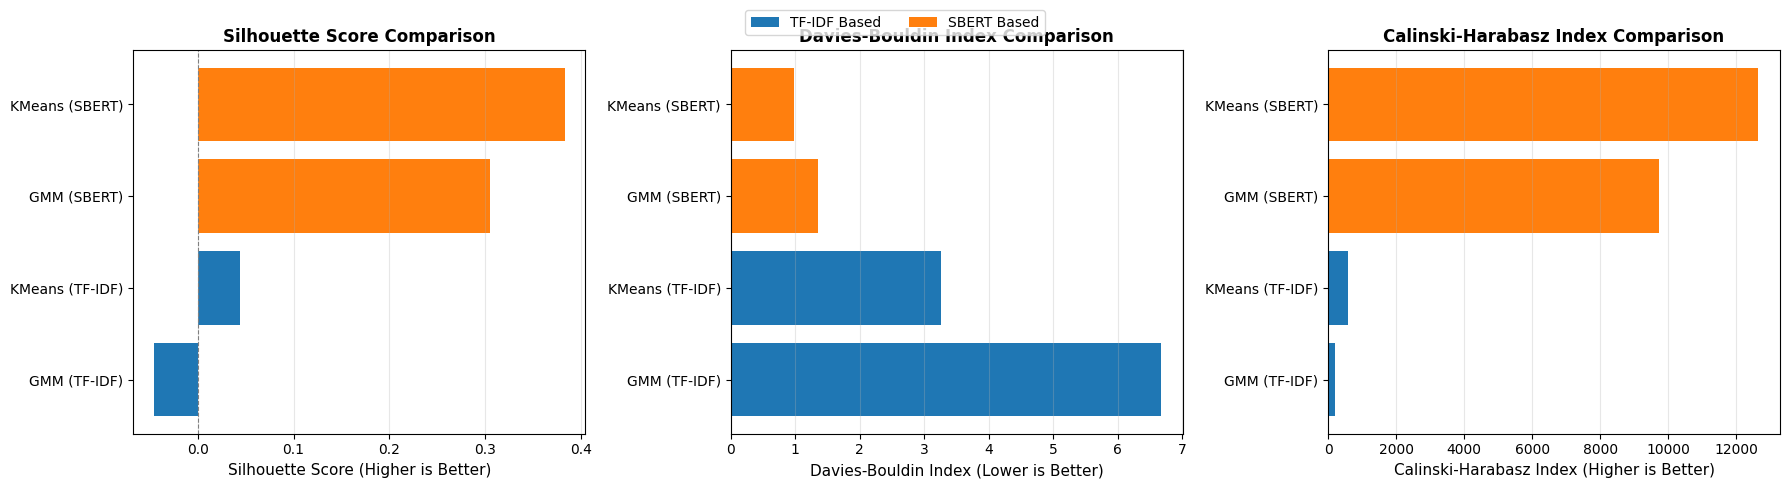

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots for visual comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Silhouette Score comparison
ax1 = axes[0]
df_comparison_valid = df_comparison[~df_comparison["Silhouette Score"].isna()]
colors = ['#1f77b4' if 'TF-IDF' in model else '#ff7f0e' for model in df_comparison_valid["Model"]]
bars1 = ax1.barh(df_comparison_valid["Model"], df_comparison_valid["Silhouette Score"], color=colors)
ax1.set_xlabel("Silhouette Score (Higher is Better)", fontsize=11)
ax1.set_title("Silhouette Score Comparison", fontsize=12, fontweight='bold')
ax1.axvline(x=0, color='gray', linestyle='--', linewidth=0.8)
ax1.grid(axis='x', alpha=0.3)

# Davies-Bouldin Index comparison
ax2 = axes[1]
df_comparison_valid_db = df_comparison[~df_comparison["Davies-Bouldin Index"].isna()]
colors2 = ['#1f77b4' if 'TF-IDF' in model else '#ff7f0e' for model in df_comparison_valid_db["Model"]]
bars2 = ax2.barh(df_comparison_valid_db["Model"], df_comparison_valid_db["Davies-Bouldin Index"], color=colors2)
ax2.set_xlabel("Davies-Bouldin Index (Lower is Better)", fontsize=11)
ax2.set_title("Davies-Bouldin Index Comparison", fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Calinski-Harabasz Index comparison
ax3 = axes[2]
df_comparison_valid_ch = df_comparison[~df_comparison["Calinski-Harabasz Index"].isna()]
colors3 = ['#1f77b4' if 'TF-IDF' in model else '#ff7f0e' for model in df_comparison_valid_ch["Model"]]
bars3 = ax3.barh(df_comparison_valid_ch["Model"], df_comparison_valid_ch["Calinski-Harabasz Index"], color=colors3)
ax3.set_xlabel("Calinski-Harabasz Index (Higher is Better)", fontsize=11)
ax3.set_title("Calinski-Harabasz Index Comparison", fontsize=12, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#1f77b4', label='TF-IDF Based'),
    Patch(facecolor='#ff7f0e', label='SBERT Based')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 5. Ranking and Best Model Selection

In [72]:
# Rank models based on each metric (excluding NaN values)
df_ranking = df_comparison.copy()

# For Silhouette Score: higher is better (rank descending)
df_ranking["Silhouette_Rank"] = df_ranking["Silhouette Score"].rank(ascending=False, na_option='bottom')

# For Davies-Bouldin: lower is better (rank ascending)
df_ranking["Davies_Rank"] = df_ranking["Davies-Bouldin Index"].rank(ascending=True, na_option='bottom')

# For Calinski-Harabasz: higher is better (rank descending)
df_ranking["Calinski_Rank"] = df_ranking["Calinski-Harabasz Index"].rank(ascending=False, na_option='bottom')

# Calculate average rank (lower is better)
df_ranking["Average_Rank"] = df_ranking[["Silhouette_Rank", "Davies_Rank", "Calinski_Rank"]].mean(axis=1)
df_ranking = df_ranking.sort_values("Average_Rank")

print("\n" + "="*100)
print("MODEL RANKING (Based on Average Rank Across All Metrics)")
print("="*100)
print("\nRanking: Lower average rank = Better overall performance\n")

df_ranking[["Model", "Representation", "Silhouette_Rank", "Davies_Rank", "Calinski_Rank", "Average_Rank"]]


MODEL RANKING (Based on Average Rank Across All Metrics)

Ranking: Lower average rank = Better overall performance



,Model,Representation,Silhouette_Rank,Davies_Rank,Calinski_Rank,Average_Rank
5,KMeans (SBERT),SBERT + UMAP,1.0,1.0,1.0,1.0
4,GMM (SBERT),SBERT + UMAP,2.0,2.0,2.0,2.0
2,KMeans (TF-IDF),TF-IDF + PCA,3.0,3.0,3.0,3.0
1,GMM (TF-IDF),TF-IDF + PCA,4.0,4.0,4.0,4.0
3,DBSCAN (SBERT),SBERT + UMAP,5.5,5.5,5.5,5.5
0,DBSCAN (TF-IDF),TF-IDF + PCA,5.5,5.5,5.5,5.5


In [73]:
# Identify the best model
best_model = df_ranking.iloc[0]

print("\n" + "="*100)
print("🏆 BEST PERFORMING MODEL")
print("="*100)
print(f"\nModel: {best_model['Model']}")
print(f"Representation: {best_model['Representation']}")
print(f"\nPerformance Metrics:")
print(f"  • Silhouette Score: {best_model['Silhouette Score']:.4f} (Rank: {int(best_model['Silhouette_Rank'])})")
print(f"  • Davies-Bouldin Index: {best_model['Davies-Bouldin Index']:.4f} (Rank: {int(best_model['Davies_Rank'])})")
print(f"  • Calinski-Harabasz Index: {best_model['Calinski-Harabasz Index']:.2f} (Rank: {int(best_model['Calinski_Rank'])})")
print(f"\nCluster Information:")
print(f"  • Number of Clusters: {int(best_model['N Clusters'])}")
print(f"  • Number of Outliers: {int(best_model['N Outliers'])}")
print(f"  • Total Samples: {int(best_model['Total Samples'])}")
print(f"\n⭐ Average Rank: {best_model['Average_Rank']:.2f}")
print("="*100)


🏆 BEST PERFORMING MODEL

Model: KMeans (SBERT)
Representation: SBERT + UMAP

Performance Metrics:
  • Silhouette Score: 0.3828 (Rank: 1)
  • Davies-Bouldin Index: 0.9900 (Rank: 1)
  • Calinski-Harabasz Index: 12656.28 (Rank: 1)

Cluster Information:
  • Number of Clusters: 12
  • Number of Outliers: 0
  • Total Samples: 23474

⭐ Average Rank: 1.00


## 6. Key Insights and Recommendations

In [74]:
print("\n" + "="*100)
print("📊 KEY INSIGHTS")
print("="*100)

print("\n1. REPRESENTATION COMPARISON:")
tfidf_avg = df_ranking[df_ranking["Representation"] == "TF-IDF + PCA"]["Average_Rank"].mean()
sbert_avg = df_ranking[df_ranking["Representation"] == "SBERT + UMAP"]["Average_Rank"].mean()
print(f"   • TF-IDF + PCA models - Average Rank: {tfidf_avg:.2f}")
print(f"   • SBERT + UMAP models - Average Rank: {sbert_avg:.2f}")
print(f"   → {'SBERT embeddings' if sbert_avg < tfidf_avg else 'TF-IDF'} provide better movie representations")

print("\n2. CLUSTERING ALGORITHM COMPARISON:")
for model_type in ["GMM", "KMeans", "DBSCAN"]:
    models = df_ranking[df_ranking["Model"].str.contains(model_type)]
    if len(models) > 0:
        avg_rank = models["Average_Rank"].mean()
        print(f"   • {model_type} - Average Rank: {avg_rank:.2f}")

print("\n3. OUTLIER DETECTION:")
total_outliers_tfidf = df_comparison[df_comparison["Representation"] == "TF-IDF + PCA"]["N Outliers"].sum()
total_outliers_sbert = df_comparison[df_comparison["Representation"] == "SBERT + UMAP"]["N Outliers"].sum()
print(f"   • TF-IDF DBSCAN detected {int(total_outliers_tfidf)} outliers")
print(f"   • SBERT DBSCAN detected {int(total_outliers_sbert)} outliers")

print("\n4. RECOMMENDATION:")
print(f"   ⭐ Use {best_model['Model']} for production recommendation system")
print(f"   • Best overall clustering quality")
print(f"   • {int(best_model['N Clusters'])} well-separated clusters")
print(f"   • Balanced performance across all metrics")

print("\n" + "="*100)


📊 KEY INSIGHTS

1. REPRESENTATION COMPARISON:
   • TF-IDF + PCA models - Average Rank: 4.17
   • SBERT + UMAP models - Average Rank: 2.83
   → SBERT embeddings provide better movie representations

2. CLUSTERING ALGORITHM COMPARISON:
   • GMM - Average Rank: 3.00
   • KMeans - Average Rank: 2.00
   • DBSCAN - Average Rank: 5.50

3. OUTLIER DETECTION:
   • TF-IDF DBSCAN detected 0 outliers
   • SBERT DBSCAN detected 0 outliers

4. RECOMMENDATION:
   ⭐ Use KMeans (SBERT) for production recommendation system
   • Best overall clustering quality
   • 12 well-separated clusters
   • Balanced performance across all metrics



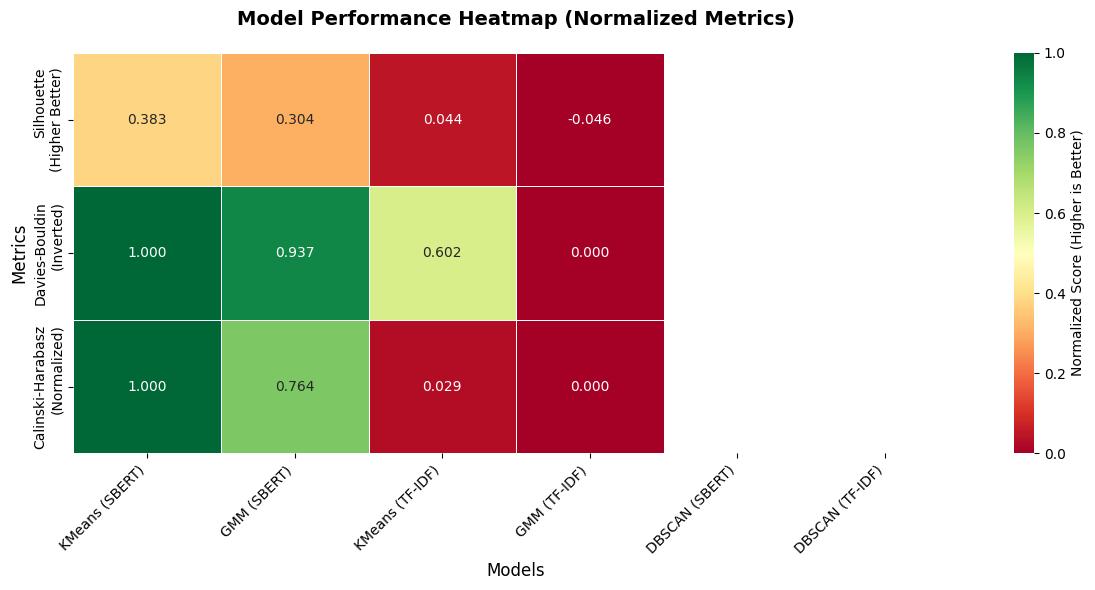

In [75]:
# Create a comprehensive comparison heatmap
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for heatmap (normalize metrics for comparison)
heatmap_data = df_ranking[["Model", "Silhouette Score", "Davies-Bouldin Index", "Calinski-Harabasz Index"]].copy()
heatmap_data = heatmap_data.set_index("Model")

# Normalize each metric to [0, 1] scale for visualization
# Silhouette: already in good range
# Davies-Bouldin: invert (lower is better) and normalize
# Calinski-Harabasz: normalize

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Create normalized versions
normalized_data = pd.DataFrame(index=heatmap_data.index)
normalized_data["Silhouette\n(Higher Better)"] = heatmap_data["Silhouette Score"]
# Invert Davies-Bouldin (lower is better → higher is better)
db_values = heatmap_data["Davies-Bouldin Index"].values.reshape(-1, 1)
normalized_data["Davies-Bouldin\n(Inverted)"] = 1 - scaler.fit_transform(db_values).flatten()
# Normalize Calinski
ch_values = heatmap_data["Calinski-Harabasz Index"].values.reshape(-1, 1)
normalized_data["Calinski-Harabasz\n(Normalized)"] = scaler.fit_transform(ch_values).flatten()

# Create heatmap
sns.heatmap(normalized_data.T, annot=True, fmt='.3f', cmap='RdYlGn', 
            center=0.5, vmin=0, vmax=1, cbar_kws={'label': 'Normalized Score (Higher is Better)'},
            linewidths=0.5, ax=ax)

plt.title("Model Performance Heatmap (Normalized Metrics)", fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Metrics", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()